In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import h5py
import tensorly as tl

In [2]:
def plot_3_echograms(echoes,cpd,dnum,dspace):
    """Plot a stack of 3 echograms.
    
    echoes   data to be plotted
    cpd      chunk per day
    dnum     number of days
    dspace   spacing between day ticks
    """
    fig,ax = plt.subplots(3,1,figsize=(16,5),sharex=True)
    plt.subplots_adjust(hspace=0.15)
    for f in range(3):
        im = ax[f].imshow(echoes[f],
                     aspect='auto', vmin=-80, vmax=-40, cmap='Spectral_r')
        ax[f].set_xticks(range(0,dnum*cpd,cpd*dspace))
        ax[f].set_xticklabels(range(0,dnum,dspace))
        ax[f].set_yticks(range(0,37,18))
        ax[f].set_yticklabels((np.arange(0,37,18)+1)*depth_bin_size)
        plt.setp(ax[f].get_xticklabels(), fontsize=13)
        plt.setp(ax[f].get_yticklabels(), fontsize=13)
        if ax[f].is_last_row():
            plt.xlabel('Day of observation',fontsize=16)
        if f==1:
            ax[f].set_ylabel('Depth (m)',fontsize=16)

    fig.subplots_adjust(right=0.95)
    cbar_ax = fig.add_axes([0.96, 0.12, 0.01, 0.76])  # [left, bottom, width, height]
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_ticks(np.arange(-80, -39, 10))

    return fig

In [3]:
# Load PCP-cleaned MVBS data
MVBS_pcp_path = '../sample_data/'
MVBS_pcp_fname = '20150817-20151017_MVBS_PCPcleaned.h5'
f_pcp = h5py.File(os.path.join(MVBS_pcp_path,MVBS_pcp_fname),'r')

# Load only low-rank data
L = np.array(f_pcp['L'])
L_sep = np.array(f_pcp['L_sep'])
depth_bin_size = np.array(f_pcp['depth_bin_size'])
ping_per_day_mvbs = np.array(f_pcp['ping_per_day_mvbs'])
ping_time = np.array(f_pcp['ping_time'])
f_pcp.close()

The low-rank data is organized with dimension `frequency` x `day of observation` x `depth` x `chunk of pings within day`.

In [4]:
L_sep.shape

(3, 62, 37, 144)

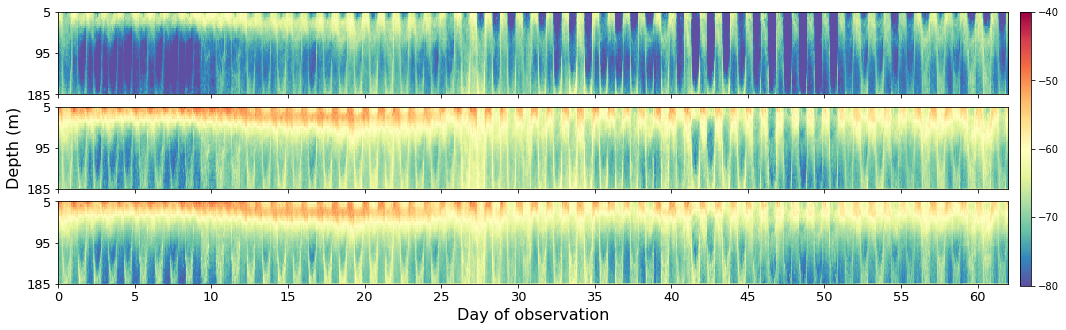

In [5]:
# Plot pcp-cleaned MVBS data
echoes_low_rank = []
for f in range(3):
    echoes_low_rank.append(tl.unfold(tl.tensor(L_sep[f,:,:,:].squeeze()),mode=1)[::-1,:])

fig = plot_3_echograms(echoes_low_rank,
                       cpd=144,dnum=65,dspace=5)

To make tensor decomposition runs faster we decimate the data by averaging over pings within each hour, so that the reduced data would contain 24 _columns_ each day.

In [6]:
# Average across time of day columns
tod_num = 6
L_sep_reduce = np.empty(np.hstack((np.array(L_sep.shape[:3]),int(L_sep.shape[-1]/tod_num))))
for i in np.arange(int(L_sep.shape[-1]/tod_num)):
    L_sep_reduce[:,:,:,i] = np.mean(L_sep[:,:,:,i*tod_num+np.arange(tod_num)],axis=3)

In [7]:
L_sep_reduce.shape

(3, 62, 37, 24)

On the grand scale the decimated data look very similar to without averaging over the pings:

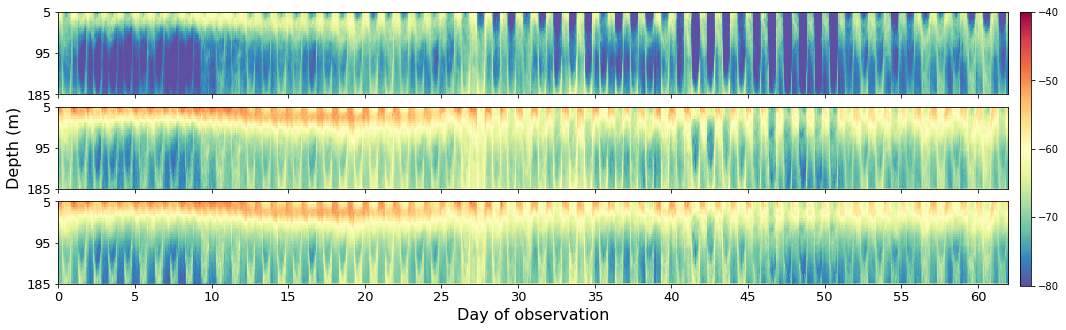

In [8]:
# Plot reduced pcp-cleaned MVBS data
echoes_low_rank_reduce = []
for f in range(3):
    echoes_low_rank_reduce.append(tl.unfold(tl.tensor(L_sep_reduce[f,:,:,:].squeeze()),mode=1)[::-1,:])

fig = plot_3_echograms(echoes_low_rank_reduce,
                       cpd=24,dnum=65,dspace=5)

Next we reshape the data for tensor decomposition.

In [9]:
L_sep_reduce_reshape = L_sep_reduce.reshape((3,62,37*24))

And perform decomposition using tensorly.

In [10]:
# kruskal decomposition is parafac in tensorly
from tensorly.decomposition import non_negative_parafac, parafac

In [11]:
sonar_tensor = tl.tensor(L_sep_reduce_reshape)
sonar_tensor.shape

(3, 62, 888)

In [12]:
kruskal_rank = 3

In [13]:
nonneg_3_rand = parafac(sonar_tensor-sonar_tensor.min(),  # non-negative kruskal
                       rank = 3,
                       n_iter_max=50000, 
                       verbose=1, 
                       tol=1e-10,
                       init='random',
                       normalize_factors=True,
                       non_negative=True)

reconstruction error=0.33484130399992745
reconstruction error=0.24821052030555893, variation=0.08663078369436852.
reconstruction error=0.19586164176954776, variation=0.05234887853601117.
reconstruction error=0.1669536312404366, variation=0.028908010529111156.
reconstruction error=0.14933408667510173, variation=0.017619544565334877.
reconstruction error=0.13741298491022633, variation=0.011921101764875403.
reconstruction error=0.12886860564463834, variation=0.008544379265587987.
reconstruction error=0.12253073009511918, variation=0.006337875549519159.
reconstruction error=0.11770701923992266, variation=0.00482371085519652.
reconstruction error=0.11395456993347892, variation=0.0037524493064437364.
reconstruction error=0.11097773385868125, variation=0.0029768360747976785.
reconstruction error=0.10857304456575304, variation=0.002404689292928211.
reconstruction error=0.10659692989598586, variation=0.0019761146697671733.
reconstruction error=0.1049459127615268, variation=0.0016510171344590596

reconstruction error=0.06511815478802091, variation=1.675384157986959e-05.
reconstruction error=0.06510165537544219, variation=1.6499412578724337e-05.
reconstruction error=0.06508540701780742, variation=1.624835763476551e-05.
reconstruction error=0.06506940638831717, variation=1.6000629490253715e-05.
reconstruction error=0.06505365020340345, variation=1.5756184913715e-05.
reconstruction error=0.06503813521897052, variation=1.55149844329322e-05.
reconstruction error=0.06502285822708816, variation=1.5276991882362534e-05.
reconstruction error=0.06500781605320892, variation=1.504217387923723e-05.
reconstruction error=0.06499300555352172, variation=1.4810499687198386e-05.
reconstruction error=0.0649784236129484, variation=1.4581940573327179e-05.
reconstruction error=0.06496406714313464, variation=1.4356469813750494e-05.
reconstruction error=0.06494993308098143, variation=1.4134062153212112e-05.
reconstruction error=0.0649360183872592, variation=1.3914693722236193e-05.
reconstruction error=0

reconstruction error=0.06405775894098867, variation=1.1635874094112486e-06.
reconstruction error=0.06405660621255561, variation=1.1527284330542509e-06.
reconstruction error=0.0640554642133994, variation=1.14199915621227e-06.
reconstruction error=0.0640543328156692, variation=1.1313977301974365e-06.
reconstruction error=0.0640532118932253, variation=1.1209224439062693e-06.
reconstruction error=0.06405210132183034, variation=1.1105713949577378e-06.
reconstruction error=0.06405100097890591, variation=1.1003429244288432e-06.
reconstruction error=0.06404991074363682, variation=1.0902352690911332e-06.
reconstruction error=0.06404883049687503, variation=1.0802467617920808e-06.
reconstruction error=0.06404776012108519, variation=1.0703757898355981e-06.
reconstruction error=0.06404669950041113, variation=1.0606206740648716e-06.
reconstruction error=0.06404564852058355, variation=1.050979827582621e-06.
reconstruction error=0.06404460706885408, variation=1.0414517294665693e-06.
reconstruction err

reconstruction error=0.06394207769840872, variation=2.8260231489662946e-07.
reconstruction error=0.06394179644221759, variation=2.8125619112862044e-07.
reconstruction error=0.06394151652012549, variation=2.799220921029244e-07.
reconstruction error=0.06394123792027394, variation=2.7859985154976563e-07.
reconstruction error=0.06394096063095563, variation=2.772893183122793e-07.
reconstruction error=0.06394068464053869, variation=2.7599041693693316e-07.
reconstruction error=0.06394040993754435, variation=2.7470299433784984e-07.
reconstruction error=0.06394013651059767, variation=2.73426946681421e-07.
reconstruction error=0.06393986434843135, variation=2.7216216631764656e-07.
reconstruction error=0.06393959343999364, variation=2.7090843771060413e-07.
reconstruction error=0.06393932377422501, variation=2.696657686318549e-07.
reconstruction error=0.06393905534027386, variation=2.6843395115050406e-07.
reconstruction error=0.06393878812738873, variation=2.6721288512443486e-07.
reconstruction er

reconstruction error=0.0639019987400589, variation=1.4508182032135775e-07.
reconstruction error=0.06390185398749539, variation=1.4475256351897947e-07.
reconstruction error=0.06390170956259203, variation=1.4442490335608849e-07.
reconstruction error=0.06390156546376173, variation=1.4409883029864456e-07.
reconstruction error=0.06390142168944002, variation=1.437743217119758e-07.
reconstruction error=0.06390127823803593, variation=1.434514040887791e-07.
reconstruction error=0.06390113510805129, variation=1.431299846421652e-07.
reconstruction error=0.0639009922979178, variation=1.428101334827181e-07.
reconstruction error=0.06390084980614673, variation=1.4249177107683586e-07.
reconstruction error=0.06390070763121712, variation=1.4217492960710842e-07.
reconstruction error=0.06390056577163829, variation=1.4185957883383615e-07.
reconstruction error=0.06390042422592714, variation=1.4154571115199133e-07.
reconstruction error=0.06390028299265357, variation=1.412332735623023e-07.
reconstruction erro

reconstruction error=0.06387704034085594, variation=9.51106934182766e-08.
reconstruction error=0.06387694542311045, variation=9.49177454828698e-08.
reconstruction error=0.06387685069816784, variation=9.472494261197895e-08.
reconstruction error=0.06387675616590771, variation=9.453226013089733e-08.
reconstruction error=0.0638766618260883, variation=9.433981941475711e-08.
reconstruction error=0.06387656767868964, variation=9.414739865487576e-08.
reconstruction error=0.06387647372341314, variation=9.395527650335467e-08.
reconstruction error=0.06387637996021038, variation=9.376320275755745e-08.
reconstruction error=0.06387628638889839, variation=9.357131199039248e-08.
reconstruction error=0.0638761930092866, variation=9.337961179300969e-08.
reconstruction error=0.06387609982129434, variation=9.318799225332963e-08.
reconstruction error=0.0638760068246875, variation=9.299660684580768e-08.
reconstruction error=0.06387591401935505, variation=9.280533244671041e-08.
reconstruction error=0.0638758

reconstruction error=0.06386162259960049, variation=6.253550016710463e-08.
reconstruction error=0.06386156018217948, variation=6.241742100954184e-08.
reconstruction error=0.06386149788231668, variation=6.229986279637778e-08.
reconstruction error=0.06386143569951962, variation=6.218279706426966e-08.
reconstruction error=0.06386137363324079, variation=6.206627882476834e-08.
reconstruction error=0.06386131168292705, variation=6.195031374001125e-08.
reconstruction error=0.06386124984809158, variation=6.183483547417268e-08.
reconstruction error=0.06386118812820393, variation=6.171988764513969e-08.
reconstruction error=0.06386112652271095, variation=6.160549298472873e-08.
reconstruction error=0.06386106503114287, variation=6.149156807355727e-08.
reconstruction error=0.06386100365293135, variation=6.137821152718548e-08.
reconstruction error=0.06386094238763312, variation=6.126529822347848e-08.
reconstruction error=0.06386088123464388, variation=6.115298924191936e-08.
reconstruction error=0.06

reconstruction error=0.06385129472761832, variation=4.593084629300748e-08.
reconstruction error=0.06385124887116662, variation=4.585645169141728e-08.
reconstruction error=0.06385120308907183, variation=4.578209479577655e-08.
reconstruction error=0.06385115738128856, variation=4.570778326662417e-08.
reconstruction error=0.06385111174781129, variation=4.563347727470912e-08.
reconstruction error=0.06385106618856813, variation=4.555924315585713e-08.
reconstruction error=0.06385102070353463, variation=4.548503350354505e-08.
reconstruction error=0.06385097529267676, variation=4.541085786569088e-08.
reconstruction error=0.06385092995593786, variation=4.533673890472212e-08.
reconstruction error=0.06385088469325549, variation=4.526268236604292e-08.
reconstruction error=0.06385083950458811, variation=4.518866737746041e-08.
reconstruction error=0.06385079438985058, variation=4.511473752910611e-08.
reconstruction error=0.06385074934902407, variation=4.504082651290986e-08.
reconstruction error=0.06

reconstruction error=0.06384287000154867, variation=3.6336858147412165e-08.
reconstruction error=0.06384283367185421, variation=3.632969446110135e-08.
reconstruction error=0.06384279734919072, variation=3.6322663488075335e-08.
reconstruction error=0.06384276103338944, variation=3.6315801282826854e-08.
reconstruction error=0.06384272472429303, variation=3.630909641005875e-08.
reconstruction error=0.06384268842175737, variation=3.630253565811703e-08.
reconstruction error=0.0638426521256744, variation=3.629608297250897e-08.
reconstruction error=0.06384261583587919, variation=3.628979521053122e-08.
reconstruction error=0.06384257955226554, variation=3.628361365526356e-08.
reconstruction error=0.06384254327471023, variation=3.6277555306996057e-08.
reconstruction error=0.06384250700309949, variation=3.627161074271079e-08.
reconstruction error=0.06384247073732716, variation=3.626577232962447e-08.
reconstruction error=0.06384243447730792, variation=3.626001923717759e-08.
reconstruction error=0

reconstruction error=0.06383571263597505, variation=3.198371917312315e-08.
reconstruction error=0.06383568069210054, variation=3.1943874517770254e-08.
reconstruction error=0.06383564878802525, variation=3.1904075284416855e-08.
reconstruction error=0.0638356169236658, variation=3.186435945656818e-08.
reconstruction error=0.06383558509892742, variation=3.182473837237687e-08.
reconstruction error=0.06383555331376849, variation=3.178515893542677e-08.
reconstruction error=0.06383552156807903, variation=3.1745689452189474e-08.
reconstruction error=0.0638354898617757, variation=3.170630333282354e-08.
reconstruction error=0.06383545819475613, variation=3.166701957602047e-08.
reconstruction error=0.06383542656689524, variation=3.162786088584113e-08.
reconstruction error=0.06383539497810964, variation=3.1588785601166514e-08.
reconstruction error=0.06383536342826285, variation=3.15498467906572e-08.
reconstruction error=0.06383533191721272, variation=3.15110501303284e-08.
reconstruction error=0.06

reconstruction error=0.06382997104010966, variation=3.014589425309744e-08.
reconstruction error=0.06382994087168602, variation=3.0168423648113674e-08.
reconstruction error=0.06382991068060397, variation=3.019108205104537e-08.
reconstruction error=0.06382988046680282, variation=3.021380114154315e-08.
reconstruction error=0.06382985023012701, variation=3.0236675815920044e-08.
reconstruction error=0.06382981997048547, variation=3.0259641542462745e-08.
reconstruction error=0.0638297896877568, variation=3.028272867189319e-08.
reconstruction error=0.06382975938190304, variation=3.0305853757073287e-08.
reconstruction error=0.06382972905279707, variation=3.0329105962789704e-08.
reconstruction error=0.06382969870035736, variation=3.035243971438728e-08.
reconstruction error=0.0638296683245364, variation=3.0375820955774735e-08.
reconstruction error=0.06382963792521093, variation=3.0399325473551286e-08.
reconstruction error=0.06382960750235434, variation=3.0422856595047065e-08.
reconstruction erro

reconstruction error=0.06382316635057836, variation=3.0505470441366533e-08.
reconstruction error=0.06382313589413238, variation=3.0456445976323465e-08.
reconstruction error=0.06382310548729704, variation=3.040683534127897e-08.
reconstruction error=0.06382307513062811, variation=3.035666892858835e-08.
reconstruction error=0.06382304482469468, variation=3.030593342945309e-08.
reconstruction error=0.06382301457005636, variation=3.025463832240227e-08.
reconstruction error=0.06382298436726325, variation=3.020279311372054e-08.
reconstruction error=0.06382295421685219, variation=3.015041105669525e-08.
reconstruction error=0.06382292411939607, variation=3.009745612458925e-08.
reconstruction error=0.06382289407542982, variation=3.0043966245396625e-08.
reconstruction error=0.06382286408545806, variation=2.998997175596152e-08.
reconstruction error=0.06382283415002331, variation=2.993543475604543e-08.
reconstruction error=0.06382280426965103, variation=2.9880372273694e-08.
reconstruction error=0.0

reconstruction error=0.06381844312166934, variation=1.8787824074273374e-08.
reconstruction error=0.06381842437543163, variation=1.8746237714917235e-08.
reconstruction error=0.0638184056704332, variation=1.8704998425156383e-08.
reconstruction error=0.06381838700650909, variation=1.866392411453699e-08.
reconstruction error=0.06381836838337476, variation=1.8623134326323232e-08.
reconstruction error=0.06381834980079508, variation=1.858257968334609e-08.
reconstruction error=0.06381833125855763, variation=1.8542237453789134e-08.
reconstruction error=0.06381831275639496, variation=1.8502162663081023e-08.
reconstruction error=0.06381829429408144, variation=1.8462313525202667e-08.
reconstruction error=0.06381827587139323, variation=1.8422688208286075e-08.
reconstruction error=0.0638182574880857, variation=1.838330752901296e-08.
reconstruction error=0.06381823914394641, variation=1.8344139290915606e-08.
reconstruction error=0.06381822083873641, variation=1.8305210000568728e-08.
reconstruction er

reconstruction error=0.06381531988300825, variation=1.3282735147890357e-08.
reconstruction error=0.06381530662059025, variation=1.3262417997150777e-08.
reconstruction error=0.06381529337846091, variation=1.3242129337509567e-08.
reconstruction error=0.06381528015660701, variation=1.3221853903400138e-08.
reconstruction error=0.06381526695496213, variation=1.320164487450537e-08.
reconstruction error=0.06381525377349595, variation=1.3181466182454749e-08.
reconstruction error=0.06381524061215917, variation=1.3161336784306421e-08.
reconstruction error=0.06381522747091006, variation=1.3141249102788244e-08.
reconstruction error=0.06381521434972777, variation=1.312118229346293e-08.
reconstruction error=0.06381520124856488, variation=1.3101162890660767e-08.
reconstruction error=0.06381518816737398, variation=1.3081190894381756e-08.
reconstruction error=0.06381517510612666, variation=1.3061247319812175e-08.
reconstruction error=0.06381516206480013, variation=1.3041326532570174e-08.
reconstruction

reconstruction error=0.06381298707052893, variation=9.812874623982282e-09.
reconstruction error=0.06381297727182336, variation=9.798705569163957e-09.
reconstruction error=0.06381296748724702, variation=9.78457634359664e-09.
reconstruction error=0.06381295771679234, variation=9.77045468142368e-09.
reconstruction error=0.06381294796042136, variation=9.756370975000372e-09.
reconstruction error=0.06381293821810564, variation=9.742315718042072e-09.
reconstruction error=0.06381292848984141, variation=9.728264235842055e-09.
reconstruction error=0.06381291877559261, variation=9.714248794256974e-09.
reconstruction error=0.0638129090753365, variation=9.700256112243899e-09.
reconstruction error=0.06381289938903324, variation=9.686303259481832e-09.
reconstruction error=0.06381288971668093, variation=9.672352307976695e-09.
reconstruction error=0.06381288005826444, variation=9.658416497138056e-09.
reconstruction error=0.0638128704137325, variation=9.644531936969791e-09.
reconstruction error=0.063812

reconstruction error=0.0638112210203739, variation=7.323184142427053e-09.
reconstruction error=0.06381121370719774, variation=7.3131761618716595e-09.
reconstruction error=0.06381120640406372, variation=7.3031340142026835e-09.
reconstruction error=0.06381119911090356, variation=7.29316015912751e-09.
reconstruction error=0.06381119182774192, variation=7.2831616432234014e-09.
reconstruction error=0.06381118455452757, variation=7.273214350234092e-09.
reconstruction error=0.0638111772912833, variation=7.263244269917202e-09.
reconstruction error=0.06381117003796356, variation=7.253319736499897e-09.
reconstruction error=0.0638111627945475, variation=7.243416061397667e-09.
reconstruction error=0.06381115556108066, variation=7.233466839395852e-09.
reconstruction error=0.06381114833748146, variation=7.2235992049085596e-09.
reconstruction error=0.06381114112372334, variation=7.213758118629343e-09.
reconstruction error=0.06381113391984805, variation=7.203875287964401e-09.
reconstruction error=0.06

reconstruction error=0.06380991036823379, variation=5.5665875103860785e-09.
reconstruction error=0.06380990480889268, variation=5.559341112459926e-09.
reconstruction error=0.0638098992568321, variation=5.552060575175766e-09.
reconstruction error=0.06380989371200654, variation=5.544825557035615e-09.
reconstruction error=0.06380988817440651, variation=5.5376000313023255e-09.
reconstruction error=0.06380988264403202, variation=5.530374491691248e-09.
reconstruction error=0.06380987712086218, variation=5.523169838150821e-09.
reconstruction error=0.06380987160487994, variation=5.51598224041161e-09.
reconstruction error=0.06380986609609857, variation=5.5087813755072546e-09.
reconstruction error=0.06380986059449152, variation=5.501607044933188e-09.
reconstruction error=0.06380985510004551, variation=5.494446009279841e-09.
reconstruction error=0.06380984961275675, variation=5.4872887622625655e-09.
reconstruction error=0.06380984413260817, variation=5.480148584924294e-09.
reconstruction error=0.

reconstruction error=0.06380896401752847, variation=4.3561145801618295e-09.
reconstruction error=0.06380895966682987, variation=4.350698606936376e-09.
reconstruction error=0.06380895532155861, variation=4.3452712539249205e-09.
reconstruction error=0.06380895098170333, variation=4.339855280699467e-09.
reconstruction error=0.06380894664723745, variation=4.334465883437666e-09.
reconstruction error=0.06380894231818376, variation=4.329053684970496e-09.
reconstruction error=0.06380893799451191, variation=4.32367185110305e-09.
reconstruction error=0.06380893367623894, variation=4.318272975312176e-09.
reconstruction error=0.06380892936330608, variation=4.3129328580748805e-09.
reconstruction error=0.06380892505576452, variation=4.3075415595561495e-09.
reconstruction error=0.06380892075355928, variation=4.302205244832713e-09.
reconstruction error=0.06380891645672827, variation=4.296831002115198e-09.
reconstruction error=0.0638089121652146, variation=4.2915136722054825e-09.
reconstruction error=0

reconstruction error=0.06380851243471135, variation=3.801267259295749e-09.
reconstruction error=0.06380850863802164, variation=3.7966897126207044e-09.
reconstruction error=0.06380850484590378, variation=3.7921178558386615e-09.
reconstruction error=0.06380850105833122, variation=3.787572561142483e-09.
reconstruction error=0.0638084972753381, variation=3.782993113210509e-09.
reconstruction error=0.06380849349688081, variation=3.778457297043403e-09.
reconstruction error=0.06380848972295364, variation=3.773927170769298e-09.
reconstruction error=0.06380848595359642, variation=3.7693572152441845e-09.
reconstruction error=0.06380848218872762, variation=3.76486880560023e-09.
reconstruction error=0.06380847842841737, variation=3.760310243738907e-09.
reconstruction error=0.06380847467257467, variation=3.755842706287815e-09.
reconstruction error=0.06380847092126586, variation=3.751308805255427e-09.
reconstruction error=0.06380846717442838, variation=3.7468374791682635e-09.
reconstruction error=0.

reconstruction error=0.06380783449987096, variation=3.031838891054406e-09.
reconstruction error=0.06380783147110532, variation=3.0287656410665775e-09.
reconstruction error=0.06380782844536358, variation=3.025741740492194e-09.
reconstruction error=0.0638078254226837, variation=3.022679870290368e-09.
reconstruction error=0.06380782240301065, variation=3.0196730532727756e-09.
reconstruction error=0.06380781938639378, variation=3.016616872963951e-09.
reconstruction error=0.0638078163727458, variation=3.0136479839404373e-09.
reconstruction error=0.06380781336212174, variation=3.010624055610478e-09.
reconstruction error=0.06380781035448746, variation=3.0076342805163137e-09.
reconstruction error=0.06380780734983153, variation=3.004655926841515e-09.
reconstruction error=0.0638078043481616, variation=3.0016699265056346e-09.
reconstruction error=0.06380780134943781, variation=2.998723797054126e-09.
reconstruction error=0.06380779835366963, variation=2.9957681751957566e-09.
reconstruction error=0

reconstruction error=0.06380751739818698, variation=2.759471220969978e-09.
reconstruction error=0.0638075146404762, variation=2.757710781953193e-09.
reconstruction error=0.06380751188452206, variation=2.75595413157248e-09.
reconstruction error=0.06380750913031699, variation=2.7542050723416978e-09.
reconstruction error=0.06380750637781926, variation=2.7524977297410658e-09.
reconstruction error=0.06380750362703264, variation=2.750786626259938e-09.
reconstruction error=0.06380750087793058, variation=2.7491020571090985e-09.
reconstruction error=0.0638074981305017, variation=2.7474288816220493e-09.
reconstruction error=0.06380749538474029, variation=2.7457614099057892e-09.
reconstruction error=0.06380749264059704, variation=2.7441432459696102e-09.
reconstruction error=0.06380748989808903, variation=2.7425080123544276e-09.
reconstruction error=0.06380748715718021, variation=2.740908819354182e-09.
reconstruction error=0.0638074844178649, variation=2.7393153162469375e-09.
reconstruction error=

reconstruction error=0.06380698025205431, variation=2.889200531597247e-09.
reconstruction error=0.06380697735851103, variation=2.8935432799803706e-09.
reconstruction error=0.06380697446059652, variation=2.897914505584076e-09.
reconstruction error=0.06380697155819505, variation=2.9024014719380986e-09.
reconstruction error=0.06380696865133129, variation=2.906863763585399e-09.
reconstruction error=0.06380696573992557, variation=2.911405713734716e-09.
reconstruction error=0.0638069628238982, variation=2.9160273778972012e-09.
reconstruction error=0.06380695990320552, variation=2.9206926738245542e-09.
reconstruction error=0.06380695697784187, variation=2.9253636457671206e-09.
reconstruction error=0.0638069540477029, variation=2.9301389786740017e-09.
reconstruction error=0.06380695111274307, variation=2.9349598307248925e-09.
reconstruction error=0.06380694817292253, variation=2.9398205397823673e-09.
reconstruction error=0.06380694522816352, variation=2.9447590060849294e-09.
reconstruction err

reconstruction error=0.0638066235388197, variation=3.704046583341558e-09.
reconstruction error=0.06380661982432512, variation=3.7144945869149737e-09.
reconstruction error=0.06380661609934646, variation=3.7249786588589018e-09.
reconstruction error=0.0638066123638325, variation=3.7355139537176285e-09.
reconstruction error=0.0638066086177586, variation=3.74607390940529e-09.
reconstruction error=0.06380660486103176, variation=3.7567268323934755e-09.
reconstruction error=0.06380660109367288, variation=3.767358883188798e-09.
reconstruction error=0.06380659731560794, variation=3.7780649442265e-09.
reconstruction error=0.0638065935268161, variation=3.788791835823702e-09.
reconstruction error=0.06380658972723093, variation=3.799585174268927e-09.
reconstruction error=0.06380658591683536, variation=3.810395568515368e-09.
reconstruction error=0.06380658209557817, variation=3.8212571856766075e-09.
reconstruction error=0.06380657826344038, variation=3.832137787651568e-09.
reconstruction error=0.0638

reconstruction error=0.06380614846252418, variation=4.8855667428293614e-09.
reconstruction error=0.0638061435689357, variation=4.893588478882549e-09.
reconstruction error=0.06380613866747535, variation=4.9014603487052e-09.
reconstruction error=0.06380613375823993, variation=4.9092354209578914e-09.
reconstruction error=0.06380612884132993, variation=4.9169100041490665e-09.
reconstruction error=0.06380612391691233, variation=4.92441759591955e-09.
reconstruction error=0.06380611898506681, variation=4.931845515310229e-09.
reconstruction error=0.06380611404596791, variation=4.939098907641437e-09.
reconstruction error=0.0638061090997029, variation=4.946265008687334e-09.
reconstruction error=0.06380610414642356, variation=4.953279342245764e-09.
reconstruction error=0.06380609918626078, variation=4.9601627805095916e-09.
reconstruction error=0.0638060942193208, variation=4.966939970429962e-09.
reconstruction error=0.06380608924578578, variation=4.973535028263143e-09.
reconstruction error=0.0638

reconstruction error=0.06380521473880932, variation=3.3855420966677485e-09.
reconstruction error=0.06380521136893814, variation=3.369871173775074e-09.
reconstruction error=0.0638052080146525, variation=3.3542856409107813e-09.
reconstruction error=0.06380520467596572, variation=3.338686785370193e-09.
reconstruction error=0.06380520135276582, variation=3.323199895821638e-09.
reconstruction error=0.06380519804504334, variation=3.307722484802156e-09.
reconstruction error=0.06380519475270342, variation=3.2923399145845522e-09.
reconstruction error=0.06380519147572328, variation=3.276980145572317e-09.
reconstruction error=0.06380518821402895, variation=3.2616943312913094e-09.
reconstruction error=0.06380518496757488, variation=3.246454063909887e-09.
reconstruction error=0.06380518173626813, variation=3.2313067499512016e-09.
reconstruction error=0.0638051785200992, variation=3.2161689283993766e-09.
reconstruction error=0.06380517531895806, variation=3.20114114382708e-09.
reconstruction error=0

reconstruction error=0.0638049217975282, variation=2.117331032724934e-09.
reconstruction error=0.0638049196872795, variation=2.110248698006245e-09.
reconstruction error=0.06380491758405998, variation=2.1032195152148603e-09.
reconstruction error=0.06380491548778808, variation=2.0962719060602097e-09.
reconstruction error=0.06380491339839169, variation=2.089396392013221e-09.
reconstruction error=0.0638049113158044, variation=2.0825872831808923e-09.
reconstruction error=0.06380490923998831, variation=2.0758160884648547e-09.
reconstruction error=0.06380490717084093, variation=2.0691473812117778e-09.
reconstruction error=0.06380490510830346, variation=2.0625374741456426e-09.
reconstruction error=0.06380490305232656, variation=2.055976902615164e-09.
reconstruction error=0.06380490100284193, variation=2.049484623678488e-09.
reconstruction error=0.06380489895978508, variation=2.0430568486995426e-09.
reconstruction error=0.06380489692309341, variation=2.0366916764213983e-09.
reconstruction error

reconstruction error=0.06380472036168557, variation=1.6292303617326809e-09.
reconstruction error=0.0638047187351208, variation=1.6265647717617071e-09.
reconstruction error=0.06380471711123488, variation=1.623885914625589e-09.
reconstruction error=0.06380471549000506, variation=1.6212298170614758e-09.
reconstruction error=0.0638047138713896, variation=1.6186154638830885e-09.
reconstruction error=0.06380471225540937, variation=1.6159802246340504e-09.
reconstruction error=0.06380471064203591, variation=1.613373462605594e-09.
reconstruction error=0.06380470903124458, variation=1.6107913336504964e-09.
reconstruction error=0.06380470742301256, variation=1.608232019778555e-09.
reconstruction error=0.06380470581733988, variation=1.6056726781510378e-09.
reconstruction error=0.0638047042142038, variation=1.6031360822177376e-09.
reconstruction error=0.06380470261357771, variation=1.600626090003665e-09.
reconstruction error=0.06380470101546543, variation=1.5981122813979454e-09.
reconstruction erro

reconstruction error=0.06380455474633819, variation=1.4017034200008993e-09.
reconstruction error=0.06380455334631381, variation=1.4000243742096075e-09.
reconstruction error=0.06380455194796088, variation=1.3983529334460343e-09.
reconstruction error=0.06380455055130216, variation=1.3966587192326685e-09.
reconstruction error=0.06380454915631678, variation=1.3949853772121656e-09.
reconstruction error=0.06380454776300663, variation=1.393310147812521e-09.
reconstruction error=0.06380454637135276, variation=1.3916538754710217e-09.
reconstruction error=0.06380454498137791, variation=1.3899748435575177e-09.
reconstruction error=0.06380454359305744, variation=1.388320472472948e-09.
reconstruction error=0.06380454220637426, variation=1.38668318494517e-09.
reconstruction error=0.06380454082137581, variation=1.3849984492608769e-09.
reconstruction error=0.06380453943800707, variation=1.3833687390052418e-09.
reconstruction error=0.06380453805628888, variation=1.3817181843123194e-09.
reconstruction e

reconstruction error=0.06380441016658697, variation=1.2336195814866002e-09.
reconstruction error=0.06380440893435996, variation=1.232227014869025e-09.
reconstruction error=0.06380440770353497, variation=1.230824983600165e-09.
reconstruction error=0.06380440647410256, variation=1.2294324169825899e-09.
reconstruction error=0.06380440524607409, variation=1.2280284705790123e-09.
reconstruction error=0.06380440401946093, variation=1.2266131582672202e-09.
reconstruction error=0.06380440279421189, variation=1.225249041114651e-09.
reconstruction error=0.06380440157037247, variation=1.2238394186958601e-09.
reconstruction error=0.06380440034792181, variation=1.2224506545921443e-09.
reconstruction error=0.06380439912685804, variation=1.2210637778675704e-09.
reconstruction error=0.06380439790718113, variation=1.2196769011429964e-09.
reconstruction error=0.06380439668888539, variation=1.2182957420669993e-09.
reconstruction error=0.0638043954719841, variation=1.2169012880702823e-09.
reconstruction e

reconstruction error=0.06380428374603218, variation=1.0905139430361643e-09.
reconstruction error=0.06380428265674004, variation=1.0892921425975644e-09.
reconstruction error=0.06380428156865833, variation=1.088081708067179e-09.
reconstruction error=0.06380428048181552, variation=1.0868428101939998e-09.
reconstruction error=0.06380427939620022, variation=1.0856153059846108e-09.
reconstruction error=0.06380427831179913, variation=1.0844010828181538e-09.
reconstruction error=0.06380427722861037, variation=1.0831887609086266e-09.
reconstruction error=0.06380427614664723, variation=1.0819631440783795e-09.
reconstruction error=0.06380427506589262, variation=1.0807546108049237e-09.
reconstruction error=0.0638042739863731, variation=1.0795195154456039e-09.
reconstruction error=0.06380427290805263, variation=1.0783204745790087e-09.
reconstruction error=0.06380427183095207, variation=1.0771005615195506e-09.
reconstruction error=0.06380427075505435, variation=1.075897718139096e-09.
reconstruction 

reconstruction error=0.063804169999526, variation=9.629574915237527e-10.
reconstruction error=0.06380416903764613, variation=9.61879867422688e-10.
reconstruction error=0.06380416807685338, variation=9.60792750914763e-10.
reconstruction error=0.0638041671171079, variation=9.59745477535634e-10.
reconstruction error=0.06380416615843816, variation=9.586697408137113e-10.
reconstruction error=0.06380416520081189, variation=9.576262699484417e-10.
reconstruction error=0.0638041642442955, variation=9.565163938685117e-10.
reconstruction error=0.06380416328883777, variation=9.554577268255926e-10.
reconstruction error=0.06380416233441594, variation=9.54421833232466e-10.
reconstruction error=0.0638041613810793, variation=9.533366318592584e-10.
reconstruction error=0.06380416042879376, variation=9.522855420884824e-10.
reconstruction error=0.06380415947758203, variation=9.51211734379065e-10.
reconstruction error=0.06380415852740809, variation=9.501739395290087e-10.
reconstruction error=0.063804157578

reconstruction error=0.06380398586417081, variation=7.597424078742421e-10.
reconstruction error=0.06380398510526131, variation=7.589095046833805e-10.
reconstruction error=0.06380398434715433, variation=7.581069799700302e-10.
reconstruction error=0.06380398358990111, variation=7.572532184640934e-10.
reconstruction error=0.0638039828334694, variation=7.56431708937022e-10.
reconstruction error=0.06380398207782884, variation=7.556405640096742e-10.
reconstruction error=0.06380398132303446, variation=7.547943797758805e-10.
reconstruction error=0.06380398056906915, variation=7.539653068544538e-10.
reconstruction error=0.0638039798159064, variation=7.531627543855279e-10.
reconstruction error=0.06380397906355945, variation=7.523469486292456e-10.
reconstruction error=0.06380397831203401, variation=7.515254391021742e-10.
reconstruction error=0.06380397756133387, variation=7.507001409390313e-10.
reconstruction error=0.06380397681144195, variation=7.49891912454892e-10.
reconstruction error=0.063803

reconstruction error=0.06380384007754912, variation=6.044109657210583e-10.
reconstruction error=0.06380383947375476, variation=6.037943617309693e-10.
reconstruction error=0.06380383887057511, variation=6.031796451200222e-10.
reconstruction error=0.06380383826802156, variation=6.025535487230727e-10.
reconstruction error=0.06380383766610169, variation=6.0191987505398e-10.
reconstruction error=0.06380383706476428, variation=6.013374104218983e-10.
reconstruction error=0.06380383646407192, variation=6.006923569668032e-10.
reconstruction error=0.06380383586397721, variation=6.000947100348597e-10.
reconstruction error=0.06380383526453325, variation=5.994439666867635e-10.
reconstruction error=0.06380383466567174, variation=5.988615020546817e-10.
reconstruction error=0.06380383406744013, variation=5.982316170216606e-10.
reconstruction error=0.06380383346981373, variation=5.97626392817574e-10.
reconstruction error=0.06380383287278309, variation=5.970306471425602e-10.
reconstruction error=0.06380

reconstruction error=0.06380377717909443, variation=5.416972842509082e-10.
reconstruction error=0.06380377663789613, variation=5.411982945124905e-10.
reconstruction error=0.06380377609720628, variation=5.406898540005756e-10.
reconstruction error=0.06380377555703819, variation=5.401680908123652e-10.
reconstruction error=0.06380377501738614, variation=5.396520452727316e-10.
reconstruction error=0.06380377447824635, variation=5.391397883691695e-10.
reconstruction error=0.06380377393960175, variation=5.386446011446111e-10.
reconstruction error=0.063803773401477, variation=5.381247530911182e-10.
reconstruction error=0.06380377286385312, variation=5.376238759735585e-10.
reconstruction error=0.06380377232673011, variation=5.371230127337867e-10.
reconstruction error=0.06380377179014213, variation=5.36587982380432e-10.
reconstruction error=0.06380377125401708, variation=5.36125047134739e-10.
reconstruction error=0.06380377071844034, variation=5.355767357384522e-10.
reconstruction error=0.063803

reconstruction error=0.06380367108289123, variation=4.6173188883447125e-10.
reconstruction error=0.0638036706213168, variation=4.615744314540038e-10.
reconstruction error=0.06380367015994919, variation=4.6136761078230393e-10.
reconstruction error=0.0638036696987542, variation=4.611949849797625e-10.
reconstruction error=0.063803669237711, variation=4.6104320361450846e-10.
reconstruction error=0.06380366877686512, variation=4.6084587534966914e-10.
reconstruction error=0.0638036683161824, variation=4.606827280762005e-10.
reconstruction error=0.06380366785567422, variation=4.605081732611538e-10.
reconstruction error=0.06380366739531781, variation=4.6035640577368753e-10.
reconstruction error=0.06380366693513027, variation=4.6018754085164204e-10.
reconstruction error=0.0638036664751097, variation=4.600205771865262e-10.
reconstruction error=0.0638036660152314, variation=4.598783021059205e-10.
reconstruction error=0.06380366555552194, variation=4.5970945106166283e-10.
reconstruction error=0.06

reconstruction error=0.06380357232104746, variation=5.098684252580199e-10.
reconstruction error=0.06380357181034234, variation=5.10705117084953e-10.
reconstruction error=0.0638035712987512, variation=5.115911444475429e-10.
reconstruction error=0.0638035707862816, variation=5.124695945379898e-10.
reconstruction error=0.06380357027291648, variation=5.133651143074403e-10.
reconstruction error=0.06380356975865586, variation=5.142606201991029e-10.
reconstruction error=0.06380356924349971, variation=5.151561538463412e-10.
reconstruction error=0.06380356872738543, variation=5.161142763165927e-10.
reconstruction error=0.06380356821036805, variation=5.17017387235974e-10.
reconstruction error=0.06380356769241341, variation=5.179546375133626e-10.
reconstruction error=0.06380356717350633, variation=5.189070839684007e-10.
reconstruction error=0.06380356665364491, variation=5.198614178025807e-10.
reconstruction error=0.06380356613282347, variation=5.208214415297618e-10.
reconstruction error=0.063803

reconstruction error=0.06380343139369204, variation=9.63579563362238e-10.
reconstruction error=0.06380343042616422, variation=9.675278217491368e-10.
reconstruction error=0.06380342945463502, variation=9.71529204307764e-10.
reconstruction error=0.06380342847908547, variation=9.755495439245365e-10.
reconstruction error=0.06380342749950418, variation=9.795812910828872e-10.
reconstruction error=0.06380342651587786, variation=9.836263192841699e-10.
reconstruction error=0.06380342552818757, variation=9.876902906658103e-10.
reconstruction error=0.06380342453641241, variation=9.917751619958892e-10.
reconstruction error=0.06380342354051444, variation=9.958979751978347e-10.
reconstruction error=0.06380342254049176, variation=1.0000226757789221e-09.
reconstruction error=0.06380342153632351, variation=1.0041682485528725e-09.
reconstruction error=0.06380342052798693, variation=1.0083365808988276e-09.
reconstruction error=0.06380341951545544, variation=1.0125314892084347e-09.
reconstruction error=0.

reconstruction error=0.06380312846761388, variation=1.9776911913682582e-09.
reconstruction error=0.06380312648634244, variation=1.9812714385780694e-09.
reconstruction error=0.06380312450148885, variation=1.9848535870448103e-09.
reconstruction error=0.06380312251310814, variation=1.988380710082893e-09.
reconstruction error=0.06380312052126481, variation=1.9918433291632454e-09.
reconstruction error=0.06380311852599872, variation=1.9952660912370135e-09.
reconstruction error=0.06380311652733071, variation=1.9986680088734943e-09.
reconstruction error=0.06380311452536326, variation=2.001967452924802e-09.
reconstruction error=0.06380311252007359, variation=2.0052896704259027e-09.
reconstruction error=0.06380311051158122, variation=2.0084923724184023e-09.
reconstruction error=0.0638031084998748, variation=2.011706412563541e-09.
reconstruction error=0.06380310648503397, variation=2.014840835840026e-09.
reconstruction error=0.06380310446711569, variation=2.0179182769197723e-09.
reconstruction er

reconstruction error=0.0638027587008901, variation=1.6419885867646755e-09.
reconstruction error=0.06380275706517206, variation=1.6357180332438048e-09.
reconstruction error=0.06380275543573595, variation=1.6294361138147195e-09.
reconstruction error=0.06380275381260642, variation=1.6231295335566998e-09.
reconstruction error=0.06380275219577398, variation=1.6168324318277527e-09.
reconstruction error=0.0638027505852804, variation=1.6104935857130798e-09.
reconstruction error=0.06380274898111996, variation=1.6041604433691958e-09.
reconstruction error=0.06380274738329457, variation=1.5978253858905944e-09.
reconstruction error=0.06380274579183838, variation=1.5914561890539858e-09.
reconstruction error=0.06380274420674949, variation=1.5850888934743068e-09.
reconstruction error=0.06380274262804689, variation=1.578702599203119e-09.
reconstruction error=0.06380274105574193, variation=1.5723049529015043e-09.
reconstruction error=0.06380273948981947, variation=1.5659224611441758e-09.
reconstruction 

reconstruction error=0.06380255981021907, variation=7.23363341448291e-10.
reconstruction error=0.06380255908979464, variation=7.204244284464423e-10.
reconstruction error=0.06380255837228446, variation=7.175101762735281e-10.
reconstruction error=0.06380255765769613, variation=7.14588332950683e-10.
reconstruction error=0.06380255694595945, variation=7.117366834785699e-10.
reconstruction error=0.06380255623708199, variation=7.088774567343137e-10.
reconstruction error=0.06380255553099547, variation=7.060865225838597e-10.
reconstruction error=0.06380255482774543, variation=7.032500415338205e-10.
reconstruction error=0.06380255412726352, variation=7.004819085887348e-10.
reconstruction error=0.06380255342952323, variation=6.97740282218362e-10.
reconstruction error=0.06380255273452265, variation=6.950005848604945e-10.
reconstruction error=0.06380255204219726, variation=6.923253914603578e-10.
reconstruction error=0.06380255135254706, variation=6.89650198060221e-10.
reconstruction error=0.063802

reconstruction error=0.06380244852739295, variation=4.4136364008018347e-10.
reconstruction error=0.0638024480866061, variation=4.407868514633151e-10.
reconstruction error=0.06380244764638274, variation=4.402233577671666e-10.
reconstruction error=0.06380244720672666, variation=4.3965607543494656e-10.
reconstruction error=0.06380244676763411, variation=4.3909255398322244e-10.
reconstruction error=0.06380244632910693, variation=4.385271729079321e-10.
reconstruction error=0.06380244589115465, variation=4.3795228554799337e-10.
reconstruction error=0.06380244545374879, variation=4.374058615308485e-10.
reconstruction error=0.06380244501688365, variation=4.368651412844926e-10.
reconstruction error=0.06380244458058011, variation=4.3630353496748597e-10.
reconstruction error=0.06380244414485715, variation=4.3572295771454606e-10.
reconstruction error=0.06380244370964835, variation=4.3520879955405434e-10.
reconstruction error=0.06380244327499357, variation=4.346547843869786e-10.
reconstruction erro

reconstruction error=0.06380236706877244, variation=3.5306137180501906e-10.
reconstruction error=0.06380236671605637, variation=3.5271607856657283e-10.
reconstruction error=0.06380236636369888, variation=3.523574904074067e-10.
reconstruction error=0.06380236601168102, variation=3.5201785930638607e-10.
reconstruction error=0.06380236566002553, variation=3.516554825111484e-10.
reconstruction error=0.06380236530872296, variation=3.513025703671957e-10.
reconstruction error=0.0638023649577543, variation=3.509686569147519e-10.
reconstruction error=0.0638023646071689, variation=3.5058540792665127e-10.
reconstruction error=0.06380236425689656, variation=3.502723389114948e-10.
reconstruction error=0.0638023639069733, variation=3.49923257036977e-10.
reconstruction error=0.06380236355742004, variation=3.495532613362329e-10.
reconstruction error=0.0638023632081931, variation=3.4922693903371993e-10.
reconstruction error=0.06380236285932098, variation=3.4887212563283754e-10.
reconstruction error=0.0

reconstruction error=0.0638023001624397, variation=2.8690808062670214e-10.
reconstruction error=0.06380229987585036, variation=2.8658934947412007e-10.
reconstruction error=0.06380229958950388, variation=2.863464743096955e-10.
reconstruction error=0.06380229930345148, variation=2.860524039860479e-10.
reconstruction error=0.06380229901767988, variation=2.857716008275446e-10.
reconstruction error=0.06380229873218717, variation=2.8549271280375876e-10.
reconstruction error=0.06380229844697147, variation=2.85215698281327e-10.
reconstruction error=0.06380229816205367, variation=2.8491779768824443e-10.
reconstruction error=0.06380229787740337, variation=2.846503033282488e-10.
reconstruction error=0.0638022975930206, variation=2.8438276733488976e-10.
reconstruction error=0.06380229730893949, variation=2.840811058613113e-10.
reconstruction error=0.06380229702513539, variation=2.838041052166673e-10.
reconstruction error=0.0638022967415988, variation=2.835365831010961e-10.
reconstruction error=0.0

reconstruction error=0.06380224477792598, variation=2.3302834661897975e-10.
reconstruction error=0.0638022445451215, variation=2.328044840238519e-10.
reconstruction error=0.06380224431254661, variation=2.3257488990235942e-10.
reconstruction error=0.0638022440801956, variation=2.3235101342944375e-10.
reconstruction error=0.06380224384804568, variation=2.3214991040632071e-10.
reconstruction error=0.06380224361614054, variation=2.319051478627543e-10.
reconstruction error=0.06380224338445736, variation=2.316831726467683e-10.
reconstruction error=0.06380224315299428, variation=2.3146308480992417e-10.
reconstruction error=0.06380224292174182, variation=2.3125246162436497e-10.
reconstruction error=0.06380224269071891, variation=2.310229091362359e-10.
reconstruction error=0.06380224245992748, variation=2.3079142763560156e-10.
reconstruction error=0.06380224222935234, variation=2.3057514231261678e-10.
reconstruction error=0.0638022419989973, variation=2.3035504059798484e-10.
reconstruction erro

reconstruction error=0.06380220391519884, variation=1.9415058449823164e-10.
reconstruction error=0.0638022037212228, variation=1.9397602968318495e-10.
reconstruction error=0.063802203527446, variation=1.9377680016141596e-10.
reconstruction error=0.06380220333384375, variation=1.9360225922415708e-10.
reconstruction error=0.06380220314042173, variation=1.9342201451610919e-10.
reconstruction error=0.06380220294717617, variation=1.9324555844413283e-10.
reconstruction error=0.06380220275410896, variation=1.930672149930146e-10.
reconstruction error=0.06380220256122199, variation=1.928869702849667e-10.
reconstruction error=0.06380220236852285, variation=1.9269913442698794e-10.
reconstruction error=0.06380220217601346, variation=1.925093973120795e-10.
reconstruction error=0.0638022019836767, variation=1.923367576317503e-10.
reconstruction error=0.06380220179152968, variation=1.9214702051684185e-10.
reconstruction error=0.06380220159955152, variation=1.9197815559479636e-10.
reconstruction error

reconstruction error=0.06380216786692135, variation=1.6060990037924938e-10.
reconstruction error=0.06380216770645944, variation=1.6046190765006685e-10.
reconstruction error=0.06380216754614364, variation=1.6031580230002618e-10.
reconstruction error=0.06380216738596822, variation=1.6017541459856233e-10.
reconstruction error=0.063802167225956, variation=1.6001222569173024e-10.
reconstruction error=0.06380216706608605, variation=1.5986995061112452e-10.
reconstruction error=0.06380216690635081, variation=1.5973523892487407e-10.
reconstruction error=0.06380216674677115, variation=1.5957965504576066e-10.
reconstruction error=0.06380216658732811, variation=1.5944304210258053e-10.
reconstruction error=0.06380216642804064, variation=1.5928747210125493e-10.
reconstruction error=0.06380216626890117, variation=1.591394654942846e-10.
reconstruction error=0.06380216610989829, variation=1.5900288030668008e-10.
reconstruction error=0.06380216595103962, variation=1.5885867621356908e-10.
reconstruction 

reconstruction error=0.06380213825281847, variation=1.336471627810809e-10.
reconstruction error=0.06380213811929084, variation=1.335276333946922e-10.
reconstruction error=0.06380213798585806, variation=1.334327787150258e-10.
reconstruction error=0.06380213785257138, variation=1.3328667336498512e-10.
reconstruction error=0.06380213771942131, variation=1.331500742995928e-10.
reconstruction error=0.06380213758635284, variation=1.3306847290728285e-10.
reconstruction error=0.06380213745343993, variation=1.3291290290595725e-10.
reconstruction error=0.06380213732062379, variation=1.3281614696936117e-10.
reconstruction error=0.06380213718794045, variation=1.3268333654004039e-10.
reconstruction error=0.063802137055352, variation=1.3258845410479836e-10.
reconstruction error=0.06380213692291532, variation=1.324366727395443e-10.
reconstruction error=0.06380213679058108, variation=1.3233424078773481e-10.
reconstruction error=0.0638021366583664, variation=1.322146836457705e-10.
reconstruction error=

reconstruction error=0.06380211245418209, variation=1.1065171001689578e-10.
reconstruction error=0.06380211234364423, variation=1.1053785664572047e-10.
reconstruction error=0.06380211223318605, variation=1.104581842659158e-10.
reconstruction error=0.06380211212283791, variation=1.1034813340859984e-10.
reconstruction error=0.06380211201258656, variation=1.1025134971642814e-10.
reconstruction error=0.06380211190243384, variation=1.10152720278478e-10.
reconstruction error=0.06380211179236273, variation=1.1007111888616805e-10.
reconstruction error=0.06380211168240923, variation=1.0995349075670902e-10.
reconstruction error=0.06380211157253922, variation=1.0987001586304501e-10.
reconstruction error=0.06380211146277927, variation=1.0975995112794124e-10.
reconstruction error=0.0638021113530914, variation=1.0968786989806745e-10.
reconstruction error=0.06380211124351738, variation=1.0957401652689214e-10.
reconstruction error=0.06380211113404201, variation=1.0947537321115419e-10.
reconstruction e

In [14]:
nonneg_3_svd = parafac(sonar_tensor-sonar_tensor.min(),  # non-negative kruskal
                       rank = 3,
                       n_iter_max=50000, 
                       verbose=1, 
                       tol=1e-10,
                       init='svd',
                       normalize_factors=True,
                       non_negative=True)

reconstruction error=0.221911039903469
reconstruction error=0.20265756598684312, variation=0.01925347391662588.
reconstruction error=0.1792881806246509, variation=0.023369385362192213.
reconstruction error=0.16231030727466902, variation=0.01697787334998188.
reconstruction error=0.15025961697920875, variation=0.01205069029546027.
reconstruction error=0.1415190135800418, variation=0.008740603399166963.
reconstruction error=0.13500652854126308, variation=0.006512485038778715.
reconstruction error=0.13002659565712632, variation=0.004979932884136756.
reconstruction error=0.12612822432115267, variation=0.0038983713359736494.
reconstruction error=0.1230129121748742, variation=0.0031153121462784705.
reconstruction error=0.12047819622501688, variation=0.0025347159498573246.
reconstruction error=0.11838328819443522, variation=0.0020949080305816548.
reconstruction error=0.11662792410304808, variation=0.0017553640913871432.
reconstruction error=0.11513910251384342, variation=0.0014888215892046586.

reconstruction error=0.07257465187268491, variation=4.440366278560259e-05.
reconstruction error=0.07253121278889096, variation=4.343908379395023e-05.
reconstruction error=0.07248869172284472, variation=4.252106604624162e-05.
reconstruction error=0.07244704419764948, variation=4.164752519524029e-05.
reconstruction error=0.0724062277142664, variation=4.0816483383082636e-05.
reconstruction error=0.07236620164818995, variation=4.002606607644843e-05.
reconstruction error=0.07232692714978656, variation=3.927449840339381e-05.
reconstruction error=0.07228836704820939, variation=3.856010157717027e-05.
reconstruction error=0.07225048575905962, variation=3.7881289149763187e-05.
reconstruction error=0.07221324919603689, variation=3.723656302273559e-05.
reconstruction error=0.0721766246861421, variation=3.6624509894792046e-05.
reconstruction error=0.07214058088914896, variation=3.6043796993137645e-05.
reconstruction error=0.07210508772043576, variation=3.5493168713193746e-05.
reconstruction error=0

reconstruction error=0.06780177518349591, variation=5.068837077294719e-05.
reconstruction error=0.06775109872863697, variation=5.067645485894168e-05.
reconstruction error=0.06770045284764052, variation=5.0645880996444403e-05.
reconstruction error=0.06764985636622373, variation=5.059648141679529e-05.
reconstruction error=0.06759932824737186, variation=5.052811885186692e-05.
reconstruction error=0.06754888756004769, variation=5.044068732416862e-05.
reconstruction error=0.06749855344726043, variation=5.033411278726474e-05.
reconstruction error=0.06744834509330759, variation=5.0208353952835294e-05.
reconstruction error=0.06739828169072826, variation=5.006340257933395e-05.
reconstruction error=0.06734838240645691, variation=4.98992842713486e-05.
reconstruction error=0.06729866634811016, variation=4.97160583467493e-05.
reconstruction error=0.06724915252955818, variation=4.951381855197723e-05.
reconstruction error=0.06719985983682941, variation=4.929269272876957e-05.
reconstruction error=0.06

reconstruction error=0.0644338508171105, variation=2.8493107250421312e-06.
reconstruction error=0.06443105499434947, variation=2.7958227610397346e-06.
reconstruction error=0.06442831119892296, variation=2.743795426501938e-06.
reconstruction error=0.06442561801352516, variation=2.6931853978062748e-06.
reconstruction error=0.06442297406301414, variation=2.6439505110137373e-06.
reconstruction error=0.06442037801313692, variation=2.5960498772209517e-06.
reconstruction error=0.06441782856926605, variation=2.549443870875079e-06.
reconstruction error=0.06441532447525022, variation=2.5040940158232994e-06.
reconstruction error=0.06441286451231265, variation=2.4599629375732235e-06.
reconstruction error=0.0644104474978508, variation=2.41701446185294e-06.
reconstruction error=0.06440807228435552, variation=2.3752134952759185e-06.
reconstruction error=0.0644057377583709, variation=2.334525984623581e-06.
reconstruction error=0.06440344283954702, variation=2.2949188238780005e-06.
reconstruction error

reconstruction error=0.064265967210781, variation=7.440769585476126e-07.
reconstruction error=0.06426522761039405, variation=7.396003869480916e-07.
reconstruction error=0.06426449243108967, variation=7.351793043786081e-07.
reconstruction error=0.06426376161811567, variation=7.308129739980185e-07.
reconstruction error=0.0642630351174436, variation=7.265006720658107e-07.
reconstruction error=0.06426231287581965, variation=7.222416239516249e-07.
reconstruction error=0.06426159484064796, variation=7.180351716956634e-07.
reconstruction error=0.06426088095991536, variation=7.138807325973717e-07.
reconstruction error=0.06426017118238167, variation=7.097775336917245e-07.
reconstruction error=0.06425946545735747, variation=7.057250241970792e-07.
reconstruction error=0.06425876373477582, variation=7.017225816530193e-07.
reconstruction error=0.06425806596509996, variation=6.977696758586616e-07.
reconstruction error=0.06425737209945144, variation=6.938656485211414e-07.
reconstruction error=0.06425

reconstruction error=0.0641746287875188, variation=4.107474867870442e-07.
reconstruction error=0.06417421917406657, variation=4.096134522263428e-07.
reconstruction error=0.06417381069669273, variation=4.084773738421976e-07.
reconstruction error=0.06417340335722044, variation=4.0733947229143475e-07.
reconstruction error=0.06417299715749926, variation=4.061997211785018e-07.
reconstruction error=0.06417259209920326, variation=4.0505829600190335e-07.
reconstruction error=0.06417218818401033, variation=4.0391519293137e-07.
reconstruction error=0.06417178541342851, variation=4.0277058181714676e-07.
reconstruction error=0.0641713837889432, variation=4.016244853077833e-07.
reconstruction error=0.06417098331183227, variation=4.0047711093171845e-07.
reconstruction error=0.06417058398335848, variation=3.993284737879854e-07.
reconstruction error=0.06417018580459212, variation=3.9817876636150107e-07.
reconstruction error=0.06416978877657518, variation=3.9702801693519696e-07.
reconstruction error=0.

reconstruction error=0.0641350252484125, variation=3.0435588245503187e-07.
reconstruction error=0.0641347213743939, variation=3.038740186006583e-07.
reconstruction error=0.06413441797300487, variation=3.034013890262921e-07.
reconstruction error=0.0641341150351204, variation=3.029378844721098e-07.
reconstruction error=0.06413381255165494, variation=3.0248346545580507e-07.
reconstruction error=0.06413351051363979, variation=3.020380151541602e-07.
reconstruction error=0.06413320891218154, variation=3.016014582524207e-07.
reconstruction error=0.06413290773849799, variation=3.011736835478729e-07.
reconstruction error=0.06413260698392383, variation=3.0075457416178786e-07.
reconstruction error=0.06413230663983126, variation=3.003440925686274e-07.
reconstruction error=0.06413200669772262, variation=2.9994210863637516e-07.
reconstruction error=0.06413170714926612, variation=2.9954845649771134e-07.
reconstruction error=0.0641314079861582, variation=2.991631079252155e-07.
reconstruction error=0.0

reconstruction error=0.06408198849968498, variation=2.677889415630963e-07.
reconstruction error=0.06408172089234945, variation=2.676073355273312e-07.
reconstruction error=0.06408145346642766, variation=2.674259217960717e-07.
reconstruction error=0.06408118622166117, variation=2.6724476648309903e-07.
reconstruction error=0.06408091915777649, variation=2.6706388468744624e-07.
reconstruction error=0.06408065227452646, variation=2.6688325002743873e-07.
reconstruction error=0.06408038557167157, variation=2.66702854884171e-07.
reconstruction error=0.06408011904891939, variation=2.6652275218752575e-07.
reconstruction error=0.06407985270601144, variation=2.663429079508006e-07.
reconstruction error=0.06407958654269118, variation=2.661633202588609e-07.
reconstruction error=0.06407932055865101, variation=2.6598404016808797e-07.
reconstruction error=0.06407905475361736, variation=2.6580503365014607e-07.
reconstruction error=0.06407878912731477, variation=2.656263025924144e-07.
reconstruction error

reconstruction error=0.06404890388214106, variation=2.445959167846068e-07.
reconstruction error=0.06404865952068041, variation=2.443614606495448e-07.
reconstruction error=0.06404841539573113, variation=2.4412494928349737e-07.
reconstruction error=0.06404817150929937, variation=2.4388643175832225e-07.
reconstruction error=0.06404792786345934, variation=2.436458400312258e-07.
reconstruction error=0.06404768446021909, variation=2.434032402437447e-07.
reconstruction error=0.06404744130161323, variation=2.431586058615487e-07.
reconstruction error=0.06404719838966688, variation=2.4291194634928903e-07.
reconstruction error=0.06404695572636934, variation=2.4266329753941385e-07.
reconstruction error=0.06404671331375902, variation=2.424126103184321e-07.
reconstruction error=0.06404647115377045, variation=2.421599885754633e-07.
reconstruction error=0.0640462292484043, variation=2.4190536615509295e-07.
reconstruction error=0.06404598759958378, variation=2.4164882050925485e-07.
reconstruction error

reconstruction error=0.06400682880445954, variation=2.143047388575292e-07.
reconstruction error=0.06400661453887276, variation=2.1426558678705465e-07.
reconstruction error=0.06400640031494816, variation=2.1422392459946593e-07.
reconstruction error=0.0640061861353661, variation=2.1417958205594e-07.
reconstruction error=0.06400597200286369, variation=2.1413250241020254e-07.
reconstruction error=0.06400575792028022, variation=2.140825834662241e-07.
reconstruction error=0.06400554389055715, variation=2.1402972306960866e-07.
reconstruction error=0.06400532991676271, variation=2.1397379444676456e-07.
reconstruction error=0.0640051160020313, variation=2.13914731400644e-07.
reconstruction error=0.06400490214958258, variation=2.1385244872162978e-07.
reconstruction error=0.06400468836275341, variation=2.1378682917017056e-07.
reconstruction error=0.06400447464497723, variation=2.1371777618461874e-07.
reconstruction error=0.06400426099976879, variation=2.1364520844113777e-07.
reconstruction error=

reconstruction error=0.06398212151341783, variation=1.7650975736582808e-07.
reconstruction error=0.06398194551626722, variation=1.759971506032354e-07.
reconstruction error=0.06398177003154785, variation=1.754847193669029e-07.
reconstruction error=0.063981595058965, variation=1.749725828531501e-07.
reconstruction error=0.06398142059819366, variation=1.7446077134330995e-07.
reconstruction error=0.06398124664873664, variation=1.739494570190958e-07.
reconstruction error=0.06398107321007591, variation=1.7343866072494496e-07.
reconstruction error=0.06398090028159505, variation=1.7292848086825074e-07.
reconstruction error=0.06398072786254137, variation=1.7241905367337829e-07.
reconstruction error=0.06398055595214139, variation=1.7191039998476487e-07.
reconstruction error=0.0639803845494683, variation=1.7140267308257684e-07.
reconstruction error=0.06398021365360858, variation=1.7089585972740462e-07.
reconstruction error=0.06398004326346697, variation=1.703901416072462e-07.
reconstruction error

reconstruction error=0.06395752179990923, variation=1.1718680689720706e-07.
reconstruction error=0.06395740480027, variation=1.1699963922695567e-07.
reconstruction error=0.06395728798668654, variation=1.1681358345894122e-07.
reconstruction error=0.06395717135813783, variation=1.1662854870753137e-07.
reconstruction error=0.06395705491357062, variation=1.1644456721082719e-07.
reconstruction error=0.06395693865192788, variation=1.1626164274358697e-07.
reconstruction error=0.0639568225721715, variation=1.1607975637650814e-07.
reconstruction error=0.06395670667327283, variation=1.1589889867269498e-07.
reconstruction error=0.06395659095418425, variation=1.1571908857532787e-07.
reconstruction error=0.06395647541390362, variation=1.1554028063465172e-07.
reconstruction error=0.06395636005139087, variation=1.1536251275090503e-07.
reconstruction error=0.0639562448655965, variation=1.1518579436098353e-07.
reconstruction error=0.0639561298555467, variation=1.1501004980318807e-07.
reconstruction err

reconstruction error=0.06394472699855189, variation=1.0233254200964215e-07.
reconstruction error=0.06394462472030847, variation=1.0227824341624281e-07.
reconstruction error=0.06394452249484943, variation=1.0222545904214897e-07.
reconstruction error=0.06394442032058478, variation=1.0217426464620427e-07.
reconstruction error=0.06394431819602495, variation=1.0212455983649171e-07.
reconstruction error=0.06394421611956858, variation=1.0207645637083651e-07.
reconstruction error=0.06394411408967302, variation=1.0202989556007402e-07.
reconstruction error=0.06394401210474639, variation=1.0198492662871761e-07.
reconstruction error=0.06394391016317409, variation=1.0194157229470591e-07.
reconstruction error=0.06394380826336232, variation=1.0189981176911278e-07.
reconstruction error=0.06394370640367562, variation=1.0185968669917944e-07.
reconstruction error=0.06394360458250313, variation=1.018211724934659e-07.
reconstruction error=0.0639435027981488, variation=1.017843543338337e-07.
reconstruction 

reconstruction error=0.06392587028222567, variation=1.2326776632765046e-07.
reconstruction error=0.06392574678483239, variation=1.234973932839889e-07.
reconstruction error=0.06392562305989197, variation=1.2372494041790194e-07.
reconstruction error=0.06392549910952207, variation=1.2395036989854002e-07.
reconstruction error=0.06392537493598811, variation=1.2417353395521857e-07.
reconstruction error=0.0639252505416161, variation=1.243943720113938e-07.
reconstruction error=0.06392512592891197, variation=1.24612704127669e-07.
reconstruction error=0.06392500110046119, variation=1.2482845078432003e-07.
reconstruction error=0.06392487605892122, variation=1.2504153996950595e-07.
reconstruction error=0.06392475080710862, variation=1.2525181260214513e-07.
reconstruction error=0.06392462534795165, variation=1.254591569660457e-07.
reconstruction error=0.06392449968445063, variation=1.2566350102161117e-07.
reconstruction error=0.06392437381973459, variation=1.2586471603848182e-07.
reconstruction err

reconstruction error=0.06391047694609005, variation=1.1568436422693118e-07.
reconstruction error=0.06391036161580334, variation=1.1533028670962508e-07.
reconstruction error=0.06391024664142386, variation=1.1497437947538547e-07.
reconstruction error=0.06391013202469616, variation=1.146167277060739e-07.
reconstruction error=0.06391001776726243, variation=1.1425743372261987e-07.
reconstruction error=0.0639099038705812, variation=1.138966812391784e-07.
reconstruction error=0.06390979033616209, variation=1.1353441910222362e-07.
reconstruction error=0.06390967716525908, variation=1.1317090300999588e-07.
reconstruction error=0.0639095643591602, variation=1.1280609887864834e-07.
reconstruction error=0.06390945191896787, variation=1.1244019233747071e-07.
reconstruction error=0.0639093398457258, variation=1.1207324206174984e-07.
reconstruction error=0.06390922814042088, variation=1.1170530492266018e-07.
reconstruction error=0.06390911680385247, variation=1.1133656840911499e-07.
reconstruction er

reconstruction error=0.06389517164175693, variation=6.986937768627133e-08.
reconstruction error=0.06389510189932351, variation=6.97424334117347e-08.
reconstruction error=0.06389503228291975, variation=6.961640376668132e-08.
reconstruction error=0.06389496279165177, variation=6.949126797606286e-08.
reconstruction error=0.06389489342464474, variation=6.936700702731002e-08.
reconstruction error=0.06389482418104839, variation=6.924359635673838e-08.
reconstruction error=0.06389475506000486, variation=6.912104352774229e-08.
reconstruction error=0.06389468606068095, variation=6.899932390724839e-08.
reconstruction error=0.06389461718224723, variation=6.88784337204984e-08.
reconstruction error=0.06389454842389322, variation=6.875835401043418e-08.
reconstruction error=0.0638944797848482, variation=6.863904501719365e-08.
reconstruction error=0.06389441126430549, variation=6.852054271200281e-08.
reconstruction error=0.06389434286150004, variation=6.840280544762045e-08.
reconstruction error=0.06389

reconstruction error=0.06388695565204063, variation=5.767819181989875e-08.
reconstruction error=0.06388689804880247, variation=5.760323815162671e-08.
reconstruction error=0.06388684052032871, variation=5.7528473762502585e-08.
reconstruction error=0.06388678306647742, variation=5.745385128763658e-08.
reconstruction error=0.06388672568705746, variation=5.737941996541984e-08.
reconstruction error=0.06388666838191549, variation=5.7305141965002804e-08.
reconstruction error=0.0638866111508945, variation=5.723102099175481e-08.
reconstruction error=0.06388655399381277, variation=5.715708173426037e-08.
reconstruction error=0.06388649691049046, variation=5.708332230514035e-08.
reconstruction error=0.06388643990078947, variation=5.700970098776459e-08.
reconstruction error=0.0638863829645376, variation=5.6936251879857736e-08.
reconstruction error=0.06388632610154173, variation=5.686299586749044e-08.
reconstruction error=0.06388626931166752, variation=5.678987420598691e-08.
reconstruction error=0.0

reconstruction error=0.06387779579704808, variation=4.6527203756419055e-08.
reconstruction error=0.06387774932268489, variation=4.647436319116238e-08.
reconstruction error=0.06387770290115288, variation=4.642153200729027e-08.
reconstruction error=0.06387765653227975, variation=4.6368873130031574e-08.
reconstruction error=0.06387761021598409, variation=4.631629565987616e-08.
reconstruction error=0.06387756395218265, variation=4.626380144256981e-08.
reconstruction error=0.06387751774077888, variation=4.621140377303323e-08.
reconstruction error=0.0638774715816592, variation=4.615911967931208e-08.
reconstruction error=0.06387742547474033, variation=4.6106918866195556e-08.
reconstruction error=0.06387737941989165, variation=4.605484868469567e-08.
reconstruction error=0.06387733341703743, variation=4.6002854220406064e-08.
reconstruction error=0.06387728746610011, variation=4.5950937319072516e-08.
reconstruction error=0.06387724156694904, variation=4.589915106323339e-08.
reconstruction error=

reconstruction error=0.06387204081294481, variation=4.0347372706750484e-08.
reconstruction error=0.06387200050534485, variation=4.030759996609401e-08.
reconstruction error=0.06387196023745705, variation=4.026788780198132e-08.
reconstruction error=0.06387192000914124, variation=4.022831580352548e-08.
reconstruction error=0.0638718798202762, variation=4.018886504142394e-08.
reconstruction error=0.06387183967078622, variation=4.0149489982654885e-08.
reconstruction error=0.06387179956053678, variation=4.011024944128305e-08.
reconstruction error=0.06387175948941613, variation=4.007112064385865e-08.
reconstruction error=0.06387171945735046, variation=4.003206567626538e-08.
reconstruction error=0.06387167946419578, variation=3.9993154676842835e-08.
reconstruction error=0.06387163950983278, variation=3.995436299863986e-08.
reconstruction error=0.0638715995941857, variation=3.9915647079280525e-08.
reconstruction error=0.06387155971712007, variation=3.987706563568505e-08.
reconstruction error=0.

reconstruction error=0.0638654349808488, variation=3.5691413449723264e-08.
reconstruction error=0.0638653992955661, variation=3.568528270103677e-08.
reconstruction error=0.063865363616073, variation=3.5679493096130166e-08.
reconstruction error=0.06386532794203778, variation=3.567403522586332e-08.
reconstruction error=0.06386529227307382, variation=3.5668963963009226e-08.
reconstruction error=0.06386525660883799, variation=3.566423582845868e-08.
reconstruction error=0.06386522094897401, variation=3.565986397835452e-08.
reconstruction error=0.06386518529311226, variation=3.565586174925084e-08.
reconstruction error=0.06386514964090398, variation=3.5652208282832554e-08.
reconstruction error=0.06386511399196818, variation=3.5648935803322956e-08.
reconstruction error=0.06386507834591632, variation=3.5646051860238614e-08.
reconstruction error=0.0638650427024053, variation=3.5643511017702245e-08.
reconstruction error=0.0638650070610466, variation=3.5641358697713343e-08.
reconstruction error=0.

reconstruction error=0.06386068535336803, variation=3.884504860829363e-08.
reconstruction error=0.06386064644679368, variation=3.890657435112743e-08.
reconstruction error=0.0638606074781229, variation=3.8968670776351466e-08.
reconstruction error=0.06386056844674899, variation=3.903137391070288e-08.
reconstruction error=0.0638605293521145, variation=3.909463448803496e-08.
reconstruction error=0.06386049019361659, variation=3.9158497916469415e-08.
reconstruction error=0.06386045097069777, variation=3.9222918815640107e-08.
reconstruction error=0.06386041168275894, variation=3.928793883278825e-08.
reconstruction error=0.0638603723292768, variation=3.935348213968126e-08.
reconstruction error=0.06386033290963138, variation=3.94196454228668e-08.
reconstruction error=0.06386029342331452, variation=3.948631685513071e-08.
reconstruction error=0.0638602538697233, variation=3.955359122176372e-08.
reconstruction error=0.0638602142483439, variation=3.962137939961252e-08.
reconstruction error=0.06386

reconstruction error=0.06385255046752512, variation=4.693414934475726e-08.
reconstruction error=0.06385250361461142, variation=4.6852913701544985e-08.
reconstruction error=0.06385245684516491, variation=4.6769446510053214e-08.
reconstruction error=0.06385241016138302, variation=4.6683781895762166e-08.
reconstruction error=0.06385236356548409, variation=4.659589893096783e-08.
reconstruction error=0.06385231705961057, variation=4.650587351329172e-08.
reconstruction error=0.06385227064597321, variation=4.6413637364017823e-08.
reconstruction error=0.06385222432663676, variation=4.631933644971831e-08.
reconstruction error=0.06385217810378542, variation=4.6222851338151294e-08.
reconstruction error=0.06385213197949914, variation=4.61242862792588e-08.
reconstruction error=0.0638520859558503, variation=4.602364883643517e-08.
reconstruction error=0.06385204003489416, variation=4.592095614874836e-08.
reconstruction error=0.06385199421866901, variation=4.581622514709949e-08.
reconstruction error=0

reconstruction error=0.06384764174945844, variation=2.9629786582607842e-08.
reconstruction error=0.0638476122225902, variation=2.9526868242091275e-08.
reconstruction error=0.06384758279741566, variation=2.942517453308202e-08.
reconstruction error=0.06384755347280495, variation=2.9324610711922716e-08.
reconstruction error=0.06384752424752395, variation=2.9225281000799797e-08.
reconstruction error=0.0638474951204257, variation=2.912709824720583e-08.
reconstruction error=0.06384746609033108, variation=2.9030094619852953e-08.
reconstruction error=0.06384743715607039, variation=2.8934260695723246e-08.
reconstruction error=0.0638474083164872, variation=2.883958317989599e-08.
reconstruction error=0.06384737957042133, variation=2.874606587488504e-08.
reconstruction error=0.0638473509166955, variation=2.8653725836491617e-08.
reconstruction error=0.06384732235421772, variation=2.856247777183185e-08.
reconstruction error=0.06384729388183161, variation=2.8472386115474535e-08.
reconstruction error=

reconstruction error=0.06384333478653043, variation=2.2931201090758968e-08.
reconstruction error=0.06384331185625207, variation=2.2930278356647626e-08.
reconstruction error=0.06384328892654001, variation=2.292971205963834e-08.
reconstruction error=0.06384326599708136, variation=2.292945865123297e-08.
reconstruction error=0.06384324306750072, variation=2.29295806369878e-08.
reconstruction error=0.06384322013742265, variation=2.2930078072413984e-08.
reconstruction error=0.06384319720652862, variation=2.2930894030825932e-08.
reconstruction error=0.06384317427444317, variation=2.293208545278702e-08.
reconstruction error=0.06384315134080226, variation=2.2933640903000097e-08.
reconstruction error=0.06384312840525133, variation=2.293555093069166e-08.
reconstruction error=0.06384310546741305, variation=2.2937838281555933e-08.
reconstruction error=0.06384308252693284, variation=2.2940480209898695e-08.
reconstruction error=0.06384305958341821, variation=2.2943514629836237e-08.
reconstruction err

reconstruction error=0.06384012194644452, variation=2.692885159305547e-08.
reconstruction error=0.06384009494789276, variation=2.699855175536392e-08.
reconstruction error=0.06384006787898465, variation=2.7068908114991075e-08.
reconstruction error=0.0638400407390754, variation=2.713990925051757e-08.
reconstruction error=0.06384001352755622, variation=2.7211519176839616e-08.
reconstruction error=0.06383998624374822, variation=2.728380800454122e-08.
reconstruction error=0.06383995888703123, variation=2.7356716988946594e-08.
reconstruction error=0.0638399314567358, variation=2.743029542395803e-08.
reconstruction error=0.06383990395227021, variation=2.75044655939638e-08.
reconstruction error=0.06383987637301433, variation=2.7579255879039977e-08.
reconstruction error=0.0638398487182968, variation=2.765471752985693e-08.
reconstruction error=0.06383982098753159, variation=2.7730765211897435e-08.
reconstruction error=0.06383979318011374, variation=2.7807417854464056e-08.
reconstruction error=0.

reconstruction error=0.06383470239428807, variation=3.729835264254522e-08.
reconstruction error=0.06383466513141524, variation=3.726287282901364e-08.
reconstruction error=0.06383462790614053, variation=3.722527470995107e-08.
reconstruction error=0.06383459072056893, variation=3.718557159415603e-08.
reconstruction error=0.06383455357685859, variation=3.7143710343578995e-08.
reconstruction error=0.06383451647705576, variation=3.7099802827067485e-08.
reconstruction error=0.0638344794232863, variation=3.705376946938621e-08.
reconstruction error=0.06383444241761166, variation=3.7005674635715025e-08.
reconstruction error=0.06383440546210273, variation=3.695550893079158e-08.
reconstruction error=0.06383436855880388, variation=3.6903298847312804e-08.
reconstruction error=0.0638343317097576, variation=3.6849046286535625e-08.
reconstruction error=0.06383429491698549, variation=3.679277210677512e-08.
reconstruction error=0.06383425818246935, variation=3.673451613728229e-08.
reconstruction error=0

reconstruction error=0.06383060074184307, variation=2.482693059469021e-08.
reconstruction error=0.06383057598213662, variation=2.475970645177128e-08.
reconstruction error=0.06383055128842927, variation=2.4693707356693295e-08.
reconstruction error=0.06383052665942579, variation=2.4629003475551414e-08.
reconstruction error=0.0638305020938632, variation=2.4565562584122347e-08.
reconstruction error=0.06383047759048803, variation=2.4503375176121445e-08.
reconstruction error=0.06383045314803727, variation=2.4442450757833356e-08.
reconstruction error=0.0638304287652157, variation=2.438282156735916e-08.
reconstruction error=0.0638304044407755, variation=2.43244401981757e-08.
reconstruction error=0.0638303801734101, variation=2.426736540883656e-08.
reconstruction error=0.06383035596189628, variation=2.421151382159259e-08.
reconstruction error=0.06383033180497677, variation=2.4156919506412855e-08.
reconstruction error=0.06383030770133925, variation=2.410363751648159e-08.
reconstruction error=0.0

reconstruction error=0.06382623205286325, variation=2.7216421769060695e-08.
reconstruction error=0.06382620479149934, variation=2.726136391628664e-08.
reconstruction error=0.06382617748549857, variation=2.7306000766058602e-08.
reconstruction error=0.06382615013515676, variation=2.735034181078344e-08.
reconstruction error=0.06382612274081145, variation=2.739434530607543e-08.
reconstruction error=0.0638260953027281, variation=2.743808334704223e-08.
reconstruction error=0.0638260678212765, variation=2.7481451600475104e-08.
reconstruction error=0.06382604029678282, variation=2.752449368426113e-08.
reconstruction error=0.0638260127295713, variation=2.7567211527412816e-08.
reconstruction error=0.06382598512002502, variation=2.7609546274232066e-08.
reconstruction error=0.06382595746849859, variation=2.765152642969504e-08.
reconstruction error=0.06382592977535609, variation=2.7693142501394874e-08.
reconstruction error=0.06382590204100146, variation=2.7734354632324987e-08.
reconstruction error=

reconstruction error=0.06382253687974183, variation=2.914171678969346e-08.
reconstruction error=0.06382250775450556, variation=2.9125236278293443e-08.
reconstruction error=0.06382247864628471, variation=2.910822084756237e-08.
reconstruction error=0.06382244955560278, variation=2.9090681932797402e-08.
reconstruction error=0.06382242048296811, variation=2.9072634660787244e-08.
reconstruction error=0.0638223914288758, variation=2.905409231257483e-08.
reconstruction error=0.06382236239388538, variation=2.9034990425835794e-08.
reconstruction error=0.06382233337849383, variation=2.9015391547759783e-08.
reconstruction error=0.0638223043832493, variation=2.899524452482094e-08.
reconstruction error=0.06382227540869623, variation=2.8974553076266396e-08.
reconstruction error=0.0638222464553619, variation=2.8953334327286306e-08.
reconstruction error=0.06382221752381345, variation=2.8931548448629663e-08.
reconstruction error=0.06382218861458391, variation=2.890922953802111e-08.
reconstruction error

reconstruction error=0.06381828539763132, variation=1.8753101460600163e-08.
reconstruction error=0.06381826671330186, variation=1.8684329458618087e-08.
reconstruction error=0.06381824809726645, variation=1.8616035407648113e-08.
reconstruction error=0.06381822954899215, variation=1.854827430536332e-08.
reconstruction error=0.06381821106800101, variation=1.8480991140212844e-08.
reconstruction error=0.06381819265382267, variation=1.8414178334924536e-08.
reconstruction error=0.06381817430593745, variation=1.8347885225034055e-08.
reconstruction error=0.0638181560238162, variation=1.828212124743711e-08.
reconstruction error=0.0638181378069639, variation=1.821685230440906e-08.
reconstruction error=0.06381811965487412, variation=1.8152089775735902e-08.
reconstruction error=0.06381810156703101, variation=1.8087843112191138e-08.
reconstruction error=0.06381808354292814, variation=1.8024102863001268e-08.
reconstruction error=0.06381806558202499, variation=1.7960903153646512e-08.
reconstruction er

reconstruction error=0.06381635730036025, variation=1.3595359116269634e-08.
reconstruction error=0.06381634372835855, variation=1.3572001703043846e-08.
reconstruction error=0.06381633017959852, variation=1.3548760030568374e-08.
reconstruction error=0.0638163166539, variation=1.3525698519534224e-08.
reconstruction error=0.0638163031511359, variation=1.3502764101280817e-08.
reconstruction error=0.06381628967115072, variation=1.3479985183639798e-08.
reconstruction error=0.06381627621381922, variation=1.3457331499155956e-08.
reconstruction error=0.0638162627789935, variation=1.343482572413457e-08.
reconstruction error=0.06381624936653697, variation=1.3412456520423e-08.
reconstruction error=0.06381623597633398, variation=1.3390202988072808e-08.
reconstruction error=0.06381622260821758, variation=1.3368116405509944e-08.
reconstruction error=0.06381620926210052, variation=1.334611705872124e-08.
reconstruction error=0.0638161959378273, variation=1.3324273226422712e-08.
reconstruction error=0.0

reconstruction error=0.06381430533989134, variation=1.0659934546186633e-08.
reconstruction error=0.06381429469396215, variation=1.064592919375329e-08.
reconstruction error=0.06381428406203832, variation=1.0631923827442158e-08.
reconstruction error=0.06381427344404397, variation=1.061799434487476e-08.
reconstruction error=0.06381426284003035, variation=1.0604013625514774e-08.
reconstruction error=0.06381425224991208, variation=1.0590118268427595e-08.
reconstruction error=0.06381424167369297, variation=1.0576219108826557e-08.
reconstruction error=0.06381423111136166, variation=1.0562331315133733e-08.
reconstruction error=0.06381422056286502, variation=1.054849663173485e-08.
reconstruction error=0.06381421002821065, variation=1.0534654371063823e-08.
reconstruction error=0.0638141995073701, variation=1.0520840545980015e-08.
reconstruction error=0.06381418900033392, variation=1.0507036185547491e-08.
reconstruction error=0.06381417850703189, variation=1.0493302032843488e-08.
reconstruction e

reconstruction error=0.06381299533889945, variation=8.962577083271306e-09.
reconstruction error=0.0638129863877543, variation=8.951145144542316e-09.
reconstruction error=0.06381297744800696, variation=8.939747345171334e-09.
reconstruction error=0.06381296851965931, variation=8.928347644543422e-09.
reconstruction error=0.06381295960268672, variation=8.916972590866656e-09.
reconstruction error=0.0638129506970664, variation=8.905620324517471e-09.
reconstruction error=0.06381294180277372, variation=8.894292677363858e-09.
reconstruction error=0.06381293291981815, variation=8.882955565558959e-09.
reconstruction error=0.06381292404816556, variation=8.871652593112067e-09.
reconstruction error=0.06381291518777991, variation=8.860385647402325e-09.
reconstruction error=0.06381290633869346, variation=8.849086449713717e-09.
reconstruction error=0.06381289750083412, variation=8.83785934713277e-09.
reconstruction error=0.06381288867423794, variation=8.826596176181312e-09.
reconstruction error=0.06381

reconstruction error=0.06381156000007891, variation=7.162911860869592e-09.
reconstruction error=0.06381155284598938, variation=7.154089529115559e-09.
reconstruction error=0.06381154570067285, variation=7.1453165328971835e-09.
reconstruction error=0.06381153856414262, variation=7.1365302278803e-09.
reconstruction error=0.06381153143636073, variation=7.127781892490859e-09.
reconstruction error=0.06381152431733857, variation=7.119022163437627e-09.
reconstruction error=0.06381151720707046, variation=7.110268110399609e-09.
reconstruction error=0.06381151010552226, variation=7.101548196719598e-09.
reconstruction error=0.0638115030126788, variation=7.092843465339449e-09.
reconstruction error=0.06381149592855143, variation=7.084127368051085e-09.
reconstruction error=0.06381148885308707, variation=7.075464353301086e-09.
reconstruction error=0.06381148178632934, variation=7.066757734541795e-09.
reconstruction error=0.06381147472824222, variation=7.058087114764078e-09.
reconstruction error=0.0638

reconstruction error=0.0638106872088055, variation=6.101939731273376e-09.
reconstruction error=0.06381068111415181, variation=6.094653698385244e-09.
reconstruction error=0.0638106750268259, variation=6.087325907233598e-09.
reconstruction error=0.06381066894679552, variation=6.080030381938606e-09.
reconstruction error=0.0638106628740417, variation=6.072753813701759e-09.
reconstruction error=0.06381065680856447, variation=6.065477231587124e-09.
reconstruction error=0.06381065075034102, variation=6.058223450677858e-09.
reconstruction error=0.06381064469940174, variation=6.050939277413292e-09.
reconstruction error=0.06381063865567833, variation=6.043723410620316e-09.
reconstruction error=0.06381063261919735, variation=6.036480981741477e-09.
reconstruction error=0.0638106265899493, variation=6.0292480452694974e-09.
reconstruction error=0.06381062056790957, variation=6.022039741870877e-09.
reconstruction error=0.0638106145530743, variation=6.014835268741692e-09.
reconstruction error=0.063810

reconstruction error=0.06380971370320919, variation=4.9504589455517944e-09.
reconstruction error=0.06380970875849426, variation=4.94471492917814e-09.
reconstruction error=0.06380970381955371, variation=4.938940548204762e-09.
reconstruction error=0.06380969888633252, variation=4.933221192660042e-09.
reconstruction error=0.06380969395885723, variation=4.927475288907246e-09.
reconstruction error=0.0638096890371127, variation=4.921744525820948e-09.
reconstruction error=0.06380968412109321, variation=4.916019494261015e-09.
reconstruction error=0.06380967921077982, variation=4.910313392003651e-09.
reconstruction error=0.06380967430618008, variation=4.90459974022972e-09.
reconstruction error=0.06380966940728265, variation=4.8988974266084284e-09.
reconstruction error=0.06380966451406095, variation=4.893221702828576e-09.
reconstruction error=0.06380965962652256, variation=4.887538387898793e-09.
reconstruction error=0.06380965474468268, variation=4.881839876791361e-09.
reconstruction error=0.063

reconstruction error=0.06380910802202433, variation=4.251850857506234e-09.
reconstruction error=0.06380910377503358, variation=4.246990745193635e-09.
reconstruction error=0.06380909953288778, variation=4.24214580130311e-09.
reconstruction error=0.06380909529556604, variation=4.2373217434832355e-09.
reconstruction error=0.06380909106307978, variation=4.232486264243995e-09.
reconstruction error=0.06380908683542327, variation=4.227656502653332e-09.
reconstruction error=0.06380908261256998, variation=4.222853289270745e-09.
reconstruction error=0.06380907839453698, variation=4.218033006209154e-09.
reconstruction error=0.06380907418130717, variation=4.213229806704355e-09.
reconstruction error=0.06380906997289386, variation=4.208413312278836e-09.
reconstruction error=0.06380906576925152, variation=4.203642336997326e-09.
reconstruction error=0.0638090615704124, variation=4.198839123614739e-09.
reconstruction error=0.06380905737633474, variation=4.194077654617878e-09.
reconstruction error=0.063

reconstruction error=0.06380842643219083, variation=3.482717350622444e-09.
reconstruction error=0.06380842295336622, variation=3.4788246033867765e-09.
reconstruction error=0.06380841947842106, variation=3.4749451649496166e-09.
reconstruction error=0.06380841600733826, variation=3.4710827961914603e-09.
reconstruction error=0.0638084125401425, variation=3.4671957666043696e-09.
reconstruction error=0.06380840907677876, variation=3.463363734690361e-09.
reconstruction error=0.0638084056172736, variation=3.4595051545682765e-09.
reconstruction error=0.06380840216161944, variation=3.4556541655961226e-09.
reconstruction error=0.06380839870981436, variation=3.4518050778808984e-09.
reconstruction error=0.06380839526184891, variation=3.447965454816959e-09.
reconstruction error=0.06380839181770598, variation=3.444142929187599e-09.
reconstruction error=0.06380838837742166, variation=3.4402843213099388e-09.
reconstruction error=0.06380838494094278, variation=3.43647887923737e-09.
reconstruction error

reconstruction error=0.0638080231718802, variation=3.0364134262494957e-09.
reconstruction error=0.06380802013881888, variation=3.033061315993457e-09.
reconstruction error=0.0638080171090888, variation=3.0297300779302816e-09.
reconstruction error=0.0638080140826672, variation=3.026421599439111e-09.
reconstruction error=0.06380801105957495, variation=3.023092248755077e-09.
reconstruction error=0.06380800803980446, variation=3.0197704892209742e-09.
reconstruction error=0.06380800502333106, variation=3.0164734043935937e-09.
reconstruction error=0.06380800201015664, variation=3.0131744183092835e-09.
reconstruction error=0.0638079990003078, variation=3.0098488423835335e-09.
reconstruction error=0.06380799599374086, variation=3.0065669398560146e-09.
reconstruction error=0.06380799299047861, variation=3.0032622500009154e-09.
reconstruction error=0.06380798999051915, variation=2.999959461402746e-09.
reconstruction error=0.06380798699383022, variation=2.9966889247834416e-09.
reconstruction error

reconstruction error=0.06380755229034187, variation=2.5237212597506442e-09.
reconstruction error=0.06380754976932776, variation=2.521014105805186e-09.
reconstruction error=0.06380754725103407, variation=2.5182936846945836e-09.
reconstruction error=0.06380754473544754, variation=2.5155865307491254e-09.
reconstruction error=0.06380754222258143, variation=2.512866109638523e-09.
reconstruction error=0.06380753971243575, variation=2.5101456885279205e-09.
reconstruction error=0.06380753720495547, variation=2.5074802789681883e-09.
reconstruction error=0.06380753470020321, variation=2.504752252829867e-09.
reconstruction error=0.06380753219814103, variation=2.5020621824412004e-09.
reconstruction error=0.06380752969876892, variation=2.4993721120525336e-09.
reconstruction error=0.06380752720210583, variation=2.4966630846057214e-09.
reconstruction error=0.06380752470812147, variation=2.4939843662474814e-09.
reconstruction error=0.06380752221680629, variation=2.4913151819294654e-09.
reconstruction 

reconstruction error=0.06380728165257404, variation=2.2332833915506e-09.
reconstruction error=0.0638072794216772, variation=2.230896842259078e-09.
reconstruction error=0.0638072771931764, variation=2.2285008005606954e-09.
reconstruction error=0.06380727496701663, variation=2.226159770413183e-09.
reconstruction error=0.06380727274324151, variation=2.2237751223785907e-09.
reconstruction error=0.06380727052183778, variation=2.2214037276313547e-09.
reconstruction error=0.06380726830281491, variation=2.219022868232834e-09.
reconstruction error=0.06380726608610841, variation=2.216706498914256e-09.
reconstruction error=0.06380726387182262, variation=2.214285796386939e-09.
reconstruction error=0.06380726165987216, variation=2.2119504561324277e-09.
reconstruction error=0.06380725945026464, variation=2.2096075247279856e-09.
reconstruction error=0.06380725724303606, variation=2.2072285804641822e-09.
reconstruction error=0.06380725503814284, variation=2.2048932124540954e-09.
reconstruction error=0

reconstruction error=0.06380694757014982, variation=1.87906384896408e-09.
reconstruction error=0.06380694569308554, variation=1.8770642817855787e-09.
reconstruction error=0.06380694381799237, variation=1.8750931640720836e-09.
reconstruction error=0.06380694194486272, variation=1.873129651386307e-09.
reconstruction error=0.06380694007370419, variation=1.871158533672812e-09.
reconstruction error=0.06380693820451677, variation=1.869187415959317e-09.
reconstruction error=0.06380693633728528, variation=1.8672314944234714e-09.
reconstruction error=0.0638069344720382, variation=1.8652470817892564e-09.
reconstruction error=0.06380693260872615, variation=1.8633120463240616e-09.
reconstruction error=0.06380693074739283, variation=1.8613333235828478e-09.
reconstruction error=0.06380692888801733, variation=1.8593755007900725e-09.
reconstruction error=0.06380692703058069, variation=1.8574366350554428e-09.
reconstruction error=0.06380692517512276, variation=1.8554579261920168e-09.
reconstruction err

reconstruction error=0.06380671770270893, variation=1.6380999195986234e-09.
reconstruction error=0.06380671606630317, variation=1.6364057608964089e-09.
reconstruction error=0.0638067144316181, variation=1.6346850678639058e-09.
reconstruction error=0.06380671279862148, variation=1.632996626810268e-09.
reconstruction error=0.06380671116733418, variation=1.6312872996859795e-09.
reconstruction error=0.06380670953774481, variation=1.6295893662254812e-09.
reconstruction error=0.06380670790985149, variation=1.6278933201441248e-09.
reconstruction error=0.06380670628365041, variation=1.6262010765766277e-09.
reconstruction error=0.06380670465914727, variation=1.6245031431161294e-09.
reconstruction error=0.06380670303634207, variation=1.6228051957778433e-09.
reconstruction error=0.06380670141521774, variation=1.6211243319963486e-09.
reconstruction error=0.06380669979579133, variation=1.6194264124136382e-09.
reconstruction error=0.0638066981780439, variation=1.6177474360112853e-09.
reconstruction 

reconstruction error=0.06380647774693066, variation=1.3890239930480774e-09.
reconstruction error=0.06380647635932574, variation=1.3876049198557894e-09.
reconstruction error=0.06380647497315127, variation=1.386174466877499e-09.
reconstruction error=0.06380647358840726, variation=1.3847440138992084e-09.
reconstruction error=0.06380647220510129, variation=1.383305969770987e-09.
reconstruction error=0.06380647082321818, variation=1.3818831079426275e-09.
reconstruction error=0.06380646944275793, variation=1.3804602461142679e-09.
reconstruction error=0.06380646806373194, variation=1.379025990622118e-09.
reconstruction error=0.0638064666861155, variation=1.3776164375922662e-09.
reconstruction error=0.06380646530992765, variation=1.3761878581153297e-09.
reconstruction error=0.06380646393516644, variation=1.3747612076508986e-09.
reconstruction error=0.06380646256180533, variation=1.3733611053945438e-09.
reconstruction error=0.0638064611898576, variation=1.3719477359730448e-09.
reconstruction er

reconstruction error=0.06380630882420926, variation=1.2152047423885648e-09.
reconstruction error=0.06380630761025854, variation=1.213950717726675e-09.
reconstruction error=0.06380630639755616, variation=1.2127023829577865e-09.
reconstruction error=0.06380630518608692, variation=1.2114692443665476e-09.
reconstruction error=0.0638063039758774, variation=1.2102095159338688e-09.
reconstruction error=0.06380630276688586, variation=1.2089915457647038e-09.
reconstruction error=0.06380630155913886, variation=1.2077469996318868e-09.
reconstruction error=0.06380630035261362, variation=1.2065252408266502e-09.
reconstruction error=0.06380629914734619, variation=1.205267427528689e-09.
reconstruction error=0.06380629794331193, variation=1.2040342611818744e-09.
reconstruction error=0.06380629674050893, variation=1.2028029960919895e-09.
reconstruction error=0.0638062955389277, variation=1.201581237286753e-09.
reconstruction error=0.06380629433857961, variation=1.2003480848177261e-09.
reconstruction er

reconstruction error=0.06380611419630591, variation=1.0164367958420684e-09.
reconstruction error=0.0638061131808822, variation=1.015423717332098e-09.
reconstruction error=0.06380611216650002, variation=1.0143821754793336e-09.
reconstruction error=0.06380611115314233, variation=1.0133576894277851e-09.
reconstruction error=0.06380611014082427, variation=1.0123180627097383e-09.
reconstruction error=0.06380610912954018, variation=1.0112840842513293e-09.
reconstruction error=0.06380610811926539, variation=1.0102747943774304e-09.
reconstruction error=0.06380610711002076, variation=1.0092446323106685e-09.
reconstruction error=0.06380610610181198, variation=1.0082087803509054e-09.
reconstruction error=0.0638061050946125, variation=1.0071994765992187e-09.
reconstruction error=0.0638061040884356, variation=1.0061769056823877e-09.
reconstruction error=0.06380610308329644, variation=1.005139152465695e-09.
reconstruction error=0.06380610207917607, variation=1.0041203701849355e-09.
reconstruction er

reconstruction error=0.06380598868506918, variation=8.891439667868539e-10.
reconstruction error=0.06380598779679983, variation=8.88269346965842e-10.
reconstruction error=0.063805986909443, variation=8.87356826906327e-10.
reconstruction error=0.06380598602298354, variation=8.864594613910981e-10.
reconstruction error=0.06380598513741577, variation=8.855677718910826e-10.
reconstruction error=0.06380598425275484, variation=8.84660927846781e-10.
reconstruction error=0.06380598336898179, variation=8.837730547384126e-10.
reconstruction error=0.06380598248608904, variation=8.828927450243995e-10.
reconstruction error=0.06380598160410313, variation=8.819859148578857e-10.
reconstruction error=0.06380598072298423, variation=8.811189000645925e-10.
reconstruction error=0.06380597984279876, variation=8.801854661788511e-10.
reconstruction error=0.06380597896347079, variation=8.79327971547994e-10.
reconstruction error=0.06380597808501744, variation=8.784533517269821e-10.
reconstruction error=0.06380597

reconstruction error=0.06380584686175701, variation=7.461476020376168e-10.
reconstruction error=0.0638058461163569, variation=7.454001166307123e-10.
reconstruction error=0.06380584537172133, variation=7.446355615448041e-10.
reconstruction error=0.06380584462780861, variation=7.439127230890463e-10.
reconstruction error=0.06380584388467184, variation=7.43136774339348e-10.
reconstruction error=0.06380584314227117, variation=7.424006687184459e-10.
reconstruction error=0.06380584240060662, variation=7.41664549219756e-10.
reconstruction error=0.06380584165970093, variation=7.409056840268491e-10.
reconstruction error=0.0638058409195105, variation=7.401904367210221e-10.
reconstruction error=0.06380584018008842, variation=7.394220791212547e-10.
reconstruction error=0.06380583944140623, variation=7.386821848642811e-10.
reconstruction error=0.06380583870346586, variation=7.3794037547259e-10.
reconstruction error=0.06380583796626538, variation=7.372004812156163e-10.
reconstruction error=0.06380583

reconstruction error=0.06380575466060841, variation=6.536520352762309e-10.
reconstruction error=0.0638057540076204, variation=6.529880108852026e-10.
reconstruction error=0.06380575335527743, variation=6.523429713078954e-10.
reconstruction error=0.06380575270357951, variation=6.516979178528004e-10.
reconstruction error=0.0638057520525437, variation=6.510358085964896e-10.
reconstruction error=0.06380575140215484, variation=6.503888538844649e-10.
reconstruction error=0.06380575075241862, variation=6.497362231572268e-10.
reconstruction error=0.06380575010332934, variation=6.490892823229899e-10.
reconstruction error=0.06380574945490028, variation=6.484290604458209e-10.
reconstruction error=0.06380574880710299, variation=6.47797288033658e-10.
reconstruction error=0.06380574815996212, variation=6.471408686703484e-10.
reconstruction error=0.06380574751347198, variation=6.464901392000399e-10.
reconstruction error=0.0638057468676307, variation=6.458412832310856e-10.
reconstruction error=0.063805

reconstruction error=0.06380565086123635, variation=5.500272182157318e-10.
reconstruction error=0.06380565031175173, variation=5.494846244680218e-10.
reconstruction error=0.06380564976281919, variation=5.489325383134513e-10.
reconstruction error=0.06380564921443493, variation=5.483842546727402e-10.
reconstruction error=0.06380564866658758, variation=5.478473508180315e-10.
reconstruction error=0.06380564811929423, variation=5.472933495287435e-10.
reconstruction error=0.0638056475725245, variation=5.467697405947547e-10.
reconstruction error=0.06380564702631823, variation=5.46206260776394e-10.
reconstruction error=0.06380564648064697, variation=5.45671258178615e-10.
reconstruction error=0.0638056459355278, variation=5.451191720240445e-10.
reconstruction error=0.06380564539094744, variation=5.445803669124061e-10.
reconstruction error=0.06380564484687172, variation=5.440757150365627e-10.
reconstruction error=0.06380564430338415, variation=5.434875743892675e-10.
reconstruction error=0.063805

reconstruction error=0.06380558332612228, variation=4.831015726347587e-10.
reconstruction error=0.06380558284349688, variation=4.82625397979497e-10.
reconstruction error=0.06380558236133821, variation=4.821586740977324e-10.
reconstruction error=0.06380558187965953, variation=4.816786830508235e-10.
reconstruction error=0.06380558139844754, variation=4.812119869246345e-10.
reconstruction error=0.06380558091771367, variation=4.807338693790797e-10.
reconstruction error=0.0638055804374484, variation=4.80265271995961e-10.
reconstruction error=0.06380557995766692, variation=4.797814784351928e-10.
reconstruction error=0.06380557947834264, variation=4.793242747158644e-10.
reconstruction error=0.06380557899949649, variation=4.788461571703095e-10.
reconstruction error=0.06380557852111515, variation=4.783813345454746e-10.
reconstruction error=0.06380557804322137, variation=4.778937801042105e-10.
reconstruction error=0.06380557756578484, variation=4.774365347515186e-10.
reconstruction error=0.06380

reconstruction error=0.0638055064456992, variation=4.0885450580674387e-10.
reconstruction error=0.06380550603721655, variation=4.084826504824335e-10.
reconstruction error=0.06380550562911334, variation=4.081032040081922e-10.
reconstruction error=0.06380550522138957, variation=4.0772377141173877e-10.
reconstruction error=0.06380550481405094, variation=4.073386350444963e-10.
reconstruction error=0.06380550440707847, variation=4.069724696131871e-10.
reconstruction error=0.06380550400048544, variation=4.0659302313894585e-10.
reconstruction error=0.06380550359426615, variation=4.062192943132814e-10.
reconstruction error=0.06380550318842251, variation=4.058436364751117e-10.
reconstruction error=0.06380550278296211, variation=4.054604013647989e-10.
reconstruction error=0.0638055023778489, variation=4.05113206869423e-10.
reconstruction error=0.06380550197315119, variation=4.046977197802448e-10.
reconstruction error=0.06380550156879496, variation=4.0435622905565793e-10.
reconstruction error=0.0

reconstruction error=0.06380545479191992, variation=3.650442170766155e-10.
reconstruction error=0.0638054544271413, variation=3.6477861009576174e-10.
reconstruction error=0.06380545406262832, variation=3.6451298923712017e-10.
reconstruction error=0.06380545369836954, variation=3.642587759200566e-10.
reconstruction error=0.06380545333434792, variation=3.640216184042089e-10.
reconstruction error=0.06380545297062416, variation=3.6372375944448976e-10.
reconstruction error=0.06380545260711667, variation=3.635074879992928e-10.
reconstruction error=0.0638054522438824, variation=3.6323427599072033e-10.
reconstruction error=0.06380545188089286, variation=3.6298954120272953e-10.
reconstruction error=0.06380545151813667, variation=3.6275618620074113e-10.
reconstruction error=0.06380545115565368, variation=3.624829880699565e-10.
reconstruction error=0.06380545079340215, variation=3.6225153432489776e-10.
reconstruction error=0.06380545043138777, variation=3.6201437680905e-10.
reconstruction error=0

reconstruction error=0.0638053949650095, variation=3.5206756954231366e-10.
reconstruction error=0.0638053946127029, variation=3.5230660055951546e-10.
reconstruction error=0.06380539426017243, variation=3.525304770324311e-10.
reconstruction error=0.06380539390741237, variation=3.527600572761358e-10.
reconstruction error=0.06380539355439051, variation=3.530218617431302e-10.
reconstruction error=0.06380539320112769, variation=3.532628217728373e-10.
reconstruction error=0.06380539284759736, variation=3.5353033001062073e-10.
reconstruction error=0.0638053924938204, variation=3.537769521777534e-10.
reconstruction error=0.06380539213975885, variation=3.5406155785011606e-10.
reconstruction error=0.06380539178543736, variation=3.543214888157564e-10.
reconstruction error=0.06380539143082752, variation=3.546098414908272e-10.
reconstruction error=0.06380539107593307, variation=3.5489444716318985e-10.
reconstruction error=0.06380539072076165, variation=3.551714200522582e-10.
reconstruction error=0.

reconstruction error=0.06380534250850232, variation=4.632356720435382e-10.
reconstruction error=0.06380534204348703, variation=4.650152901630733e-10.
reconstruction error=0.06380534157667697, variation=4.668100628268945e-10.
reconstruction error=0.06380534110807784, variation=4.685991317199267e-10.
reconstruction error=0.06380534063765544, variation=4.704223954821174e-10.
reconstruction error=0.06380534016539845, variation=4.72256997396947e-10.
reconstruction error=0.0638053396912632, variation=4.741352449544323e-10.
reconstruction error=0.0638053392152478, variation=4.76015407646635e-10.
reconstruction error=0.0638053387373105, variation=4.779373008467758e-10.
reconstruction error=0.06380533825746079, variation=4.79849701640056e-10.
reconstruction error=0.06380533777567782, variation=4.817829746261992e-10.
reconstruction error=0.06380533729187049, variation=4.838073275337251e-10.
reconstruction error=0.06380533680610523, variation=4.857652613488028e-10.
reconstruction error=0.06380533

reconstruction error=0.06380522872134017, variation=1.151916742547776e-09.
reconstruction error=0.06380522756104147, variation=1.160298704339091e-09.
reconstruction error=0.0638052263922868, variation=1.1687546624949974e-09.
reconstruction error=0.06380522521500787, variation=1.1772789410002815e-09.
reconstruction error=0.0638052240291079, variation=1.185899961564374e-09.
reconstruction error=0.06380522283455277, variation=1.1945551353642614e-09.
reconstruction error=0.06380522163125518, variation=1.2032975865716722e-09.
reconstruction error=0.06380522041914496, variation=1.212110217752027e-09.
reconstruction error=0.06380521919814432, variation=1.2210006478108326e-09.
reconstruction error=0.06380521796817544, variation=1.2299688767480887e-09.
reconstruction error=0.06380521672917953, variation=1.2389959058722866e-09.
reconstruction error=0.06380521548108259, variation=1.2480969452388635e-09.
reconstruction error=0.06380521422378028, variation=1.2573023039363918e-09.
reconstruction err

reconstruction error=0.06380486671277327, variation=3.5162935341226387e-09.
reconstruction error=0.06380486317887885, variation=3.533894427087958e-09.
reconstruction error=0.06380485962749549, variation=3.551383354061244e-09.
reconstruction error=0.06380485605863269, variation=3.568862802505457e-09.
reconstruction error=0.06380485247234355, variation=3.5862891406557296e-09.
reconstruction error=0.06380484886870205, variation=3.6036414963191987e-09.
reconstruction error=0.06380484524774994, variation=3.620952107596942e-09.
reconstruction error=0.06380484160955174, variation=3.6381982010391667e-09.
reconstruction error=0.06380483795421746, variation=3.655334285257439e-09.
reconstruction error=0.06380483428174141, variation=3.6724760454909244e-09.
reconstruction error=0.06380483059226591, variation=3.6894755028882287e-09.
reconstruction error=0.06380482688582506, variation=3.7064408486831013e-09.
reconstruction error=0.0638048231624853, variation=3.723339761507738e-09.
reconstruction erro

reconstruction error=0.06380438344974147, variation=4.495179076191569e-09.
reconstruction error=0.06380437896049101, variation=4.489250457484495e-09.
reconstruction error=0.0638043744774822, variation=4.483008811395628e-09.
reconstruction error=0.06380437000097684, variation=4.4765053608397665e-09.
reconstruction error=0.06380436553128611, variation=4.46969072864789e-09.
reconstruction error=0.06380436106871926, variation=4.462566857710293e-09.
reconstruction error=0.06380435661357983, variation=4.455139424042187e-09.
reconstruction error=0.06380435216611069, variation=4.4474691429652324e-09.
reconstruction error=0.06380434772666092, variation=4.439449766135972e-09.
reconstruction error=0.0638043432954734, variation=4.431187528020075e-09.
reconstruction error=0.06380433887285544, variation=4.422617952415386e-09.
reconstruction error=0.06380433445911445, variation=4.413740997688542e-09.
reconstruction error=0.06380433005449135, variation=4.404623096809779e-09.
reconstruction error=0.063

reconstruction error=0.0638038697034372, variation=1.667394763926744e-09.
reconstruction error=0.06380386805143874, variation=1.6519984546992106e-09.
reconstruction error=0.06380386641470184, variation=1.6367368987912911e-09.
reconstruction error=0.06380386479309563, variation=1.6216062104223994e-09.
reconstruction error=0.0638038631864645, variation=1.6066311336881967e-09.
reconstruction error=0.06380386159467187, variation=1.5917926282638106e-09.
reconstruction error=0.06380386001758302, variation=1.5770888484034629e-09.
reconstruction error=0.06380385845507273, variation=1.562510287822505e-09.
reconstruction error=0.06380385690698737, variation=1.5480853682303675e-09.
reconstruction error=0.06380385537318836, variation=1.5337990044717031e-09.
reconstruction error=0.06380385385354105, variation=1.5196473107659259e-09.
reconstruction error=0.06380385234790314, variation=1.505637906018542e-09.
reconstruction error=0.06380385085612474, variation=1.4917784091350583e-09.
reconstruction er

reconstruction error=0.06380373755374184, variation=6.248550288301402e-10.
reconstruction error=0.06380373693165302, variation=6.220888248975598e-10.
reconstruction error=0.0638037363122754, variation=6.193776186380617e-10.
reconstruction error=0.06380373569556913, variation=6.167062693851477e-10.
reconstruction error=0.06380373508153231, variation=6.140368213891634e-10.
reconstruction error=0.0638037344700625, variation=6.114698053449885e-10.
reconstruction error=0.06380373386117297, variation=6.088895360134572e-10.
reconstruction error=0.06380373325479541, variation=6.063775592757281e-10.
reconstruction error=0.06380373265093554, variation=6.038598648894222e-10.
reconstruction error=0.06380373204951366, variation=6.014218845162844e-10.
reconstruction error=0.06380373145048802, variation=5.990256346510847e-10.
reconstruction error=0.0638037308538795, variation=5.966085264708099e-10.
reconstruction error=0.06380373025960083, variation=5.942786679424827e-10.
reconstruction error=0.06380

reconstruction error=0.06380366022746842, variation=4.3784909031785446e-10.
reconstruction error=0.06380365979019799, variation=4.37270428199632e-10.
reconstruction error=0.06380365935349674, variation=4.367012446104823e-10.
reconstruction error=0.0638036589173457, variation=4.361510458350537e-10.
reconstruction error=0.06380365848176195, variation=4.3558374962504587e-10.
reconstruction error=0.06380365804675117, variation=4.3501077739982463e-10.
reconstruction error=0.06380365761229438, variation=4.344567899883245e-10.
reconstruction error=0.06380365717838402, variation=4.339103659711796e-10.
reconstruction error=0.06380365674502575, variation=4.333582659388213e-10.
reconstruction error=0.0638036563122158, variation=4.3280995454253457e-10.
reconstruction error=0.06380365587997312, variation=4.3224267221031454e-10.
reconstruction error=0.0638036554482503, variation=4.317228241568216e-10.
reconstruction error=0.06380365501709476, variation=4.311555418246016e-10.
reconstruction error=0.0

reconstruction error=0.0638036064509911, variation=3.742907234149939e-10.
reconstruction error=0.06380360607711967, variation=3.738714338119564e-10.
reconstruction error=0.0638036057036884, variation=3.7343127201605597e-10.
reconstruction error=0.06380360533066316, variation=3.7302523570037494e-10.
reconstruction error=0.06380360495809514, variation=3.725680181032587e-10.
reconstruction error=0.06380360458593694, variation=3.721582070292939e-10.
reconstruction error=0.06380360421417718, variation=3.7175976186354376e-10.
reconstruction error=0.06380360384287843, variation=3.7129874175256816e-10.
reconstruction error=0.06380360347198191, variation=3.708965218285343e-10.
reconstruction error=0.06380360310148572, variation=3.7049618928364225e-10.
reconstruction error=0.06380360273143158, variation=3.7005414010859994e-10.
reconstruction error=0.06380360236179106, variation=3.6964052652077584e-10.
reconstruction error=0.06380360199257361, variation=3.692174482816668e-10.
reconstruction error

reconstruction error=0.06380354861099015, variation=3.0872307488216677e-10.
reconstruction error=0.06380354830260482, variation=3.08385331160288e-10.
reconstruction error=0.06380354799458754, variation=3.0801727834983694e-10.
reconstruction error=0.06380354768690417, variation=3.076833648973931e-10.
reconstruction error=0.06380354737956612, variation=3.073380577811591e-10.
reconstruction error=0.06380354707258284, variation=3.069832721358523e-10.
reconstruction error=0.0638035467659449, variation=3.0663795114183046e-10.
reconstruction error=0.06380354645966362, variation=3.062812781173818e-10.
reconstruction error=0.06380354615371246, variation=3.0595115330100953e-10.
reconstruction error=0.0638035458481085, variation=3.056039588056336e-10.
reconstruction error=0.06380354554285936, variation=3.0524914540475123e-10.
reconstruction error=0.0638035452379479, variation=3.049114571940237e-10.
reconstruction error=0.06380354493336089, variation=3.045870083928648e-10.
reconstruction error=0.0

reconstruction error=0.06380350996637339, variation=2.6529455021684356e-10.
reconstruction error=0.06380350970137103, variation=2.6500236727233784e-10.
reconstruction error=0.06380350943664377, variation=2.647272540068357e-10.
reconstruction error=0.06380350917223336, variation=2.644104102333955e-10.
reconstruction error=0.06380350890811702, variation=2.641163399097479e-10.
reconstruction error=0.06380350864428906, variation=2.6382795947910154e-10.
reconstruction error=0.0638035083807476, variation=2.63541466427597e-10.
reconstruction error=0.06380350811751538, variation=2.632322138040877e-10.
reconstruction error=0.06380350785456586, variation=2.629495232664425e-10.
reconstruction error=0.06380350759191801, variation=2.6264784791507623e-10.
reconstruction error=0.06380350732957182, variation=2.6234618644149776e-10.
reconstruction error=0.06380350706750454, variation=2.620672845399241e-10.
reconstruction error=0.06380350680570288, variation=2.6180166368128255e-10.
reconstruction error=

reconstruction error=0.06380346932057947, variation=2.2039559066655556e-10.
reconstruction error=0.0638034691004419, variation=2.2013756095784487e-10.
reconstruction error=0.0638034688805377, variation=2.1990420595585647e-10.
reconstruction error=0.06380346866086876, variation=2.196689358191506e-10.
reconstruction error=0.06380346844145406, variation=2.1941470862429924e-10.
reconstruction error=0.06380346822226704, variation=2.1918701575973643e-10.
reconstruction error=0.06380346800332855, variation=2.1893849233567408e-10.
reconstruction error=0.06380346778461395, variation=2.1871460198497061e-10.
reconstruction error=0.06380346756613839, variation=2.18475557089981e-10.
reconstruction error=0.06380346734792088, variation=2.182175135034825e-10.
reconstruction error=0.06380346712992722, variation=2.1799365090835465e-10.
reconstruction error=0.06380346691218022, variation=2.1774700098564637e-10.
reconstruction error=0.06380346669466849, variation=2.175117308489405e-10.
reconstruction erro

reconstruction error=0.06380344166374981, variation=1.9037312004588358e-10.
reconstruction error=0.06380344147357779, variation=1.9017201702276054e-10.
reconstruction error=0.06380344128358413, variation=1.899936596938545e-10.
reconstruction error=0.06380344109382952, variation=1.897546147988649e-10.
reconstruction error=0.06380344090427223, variation=1.895572865340256e-10.
reconstruction error=0.06380344071489708, variation=1.8937515444683584e-10.
reconstruction error=0.06380344052574959, variation=1.8914748933784864e-10.
reconstruction error=0.06380344033679183, variation=1.889577522229402e-10.
reconstruction error=0.06380344014803899, variation=1.8875284668595782e-10.
reconstruction error=0.06380343995948726, variation=1.8855172978504697e-10.
reconstruction error=0.06380343977112524, variation=1.8836202042571415e-10.
reconstruction error=0.0638034395829947, variation=1.881305389250798e-10.
reconstruction error=0.0638034393950501, variation=1.879446043240307e-10.
reconstruction error

reconstruction error=0.06380341271970146, variation=1.5953099952170646e-10.
reconstruction error=0.06380341256032224, variation=1.593792181564524e-10.
reconstruction error=0.06380341240114222, variation=1.5918001639025903e-10.
reconstruction error=0.0638034122421045, variation=1.590377135540777e-10.
reconstruction error=0.06380341208324705, variation=1.58857454968242e-10.
reconstruction error=0.06380341192454327, variation=1.5870378622384607e-10.
reconstruction error=0.06380341176602161, variation=1.585216541366563e-10.
reconstruction error=0.06380341160764984, variation=1.5837177402833191e-10.
reconstruction error=0.0638034114494659, variation=1.5818393817035314e-10.
reconstruction error=0.06380341129143945, variation=1.5802645303431007e-10.
reconstruction error=0.06380341113357804, variation=1.5786140450391173e-10.
reconstruction error=0.06380341097587981, variation=1.5769822947486745e-10.
reconstruction error=0.06380341081835043, variation=1.5752937843060977e-10.
reconstruction erro

reconstruction error=0.06380338936838555, variation=1.3509215968099397e-10.
reconstruction error=0.06380338923342997, variation=1.3495557449338946e-10.
reconstruction error=0.06380338909860532, variation=1.3482465144321054e-10.
reconstruction error=0.06380338896394383, variation=1.3466149029195407e-10.
reconstruction error=0.06380338882939238, variation=1.345514533124259e-10.
reconstruction error=0.06380338869500031, variation=1.3439206691945316e-10.
reconstruction error=0.06380338856074863, variation=1.342516792179893e-10.
reconstruction error=0.06380338842663355, variation=1.34115080152597e-10.
reconstruction error=0.06380338829264749, variation=1.3398605835934774e-10.
reconstruction error=0.06380338815881323, variation=1.3383426311630586e-10.
reconstruction error=0.06380338802510417, variation=1.3370905771470376e-10.
reconstruction error=0.0638033878915393, variation=1.3356486749938057e-10.
reconstruction error=0.06380338775812622, variation=1.334130861341265e-10.
reconstruction err

reconstruction error=0.06380337329678644, variation=1.1853462655864178e-10.
reconstruction error=0.06380337317836945, variation=1.1841698455139493e-10.
reconstruction error=0.06380337306008148, variation=1.182879766359335e-10.
reconstruction error=0.06380337294192631, variation=1.181551662066127e-10.
reconstruction error=0.0638033728238774, variation=1.1804891786315608e-10.
reconstruction error=0.0638033727059556, variation=1.179217973268365e-10.
reconstruction error=0.06380337258813815, variation=1.1781745024030954e-10.
reconstruction error=0.0638033724704573, variation=1.1768085117491722e-10.
reconstruction error=0.06380337235289409, variation=1.1756320916767038e-10.
reconstruction error=0.0638033722354542, variation=1.1743989114521014e-10.
reconstruction error=0.06380337211813383, variation=1.1732036175882143e-10.
reconstruction error=0.063803372000933, variation=1.1720083237243273e-10.
reconstruction error=0.06380337188383842, variation=1.170945840289761e-10.
reconstruction error=0

reconstruction error=0.06380335845719537, variation=1.0343606526852511e-10.
reconstruction error=0.06380335835385227, variation=1.0334309796800056e-10.
reconstruction error=0.06380335825060782, variation=1.0324445465226262e-10.
reconstruction error=0.06380335814745255, variation=1.031552621100218e-10.
reconstruction error=0.0638033580444206, variation=1.0303195796534936e-10.
reconstruction error=0.06380335794150058, variation=1.0292001972889153e-10.
reconstruction error=0.06380335783867354, variation=1.0282703855057918e-10.
reconstruction error=0.06380335773595654, variation=1.0271700157105101e-10.
reconstruction error=0.06380335763334578, variation=1.0261075322759439e-10.
reconstruction error=0.0638033575308204, variation=1.0252537707700071e-10.
reconstruction error=0.06380335742840697, variation=1.0241343884054288e-10.
reconstruction error=0.06380335732610927, variation=1.0229769809022571e-10.
reconstruction error=0.06380335722389505, variation=1.022142231965617e-10.
reconstruction e

First we check the reconstruction results:

In [15]:
# Reconstruction
full_nonneg_3_svd = tl.kruskal_to_tensor(nonneg_3_svd)
full_nonneg_3_rand = tl.kruskal_to_tensor(nonneg_3_rand)

In [16]:
def plot_1_echogram_on_ax(ax, echoes, cpd, dnum, dspace):
    ax.imshow(echoes,
             aspect='auto',vmax=-40, vmin=-80,cmap='Spectral_r')
    ax.set_xticks(range(0,dnum*cpd,cpd*dspace))
    ax.set_xticklabels(range(0,dnum,dspace))
    ax.set_yticks(range(0,37,18))
    ax.set_yticklabels((np.arange(0,37,18)+1)*depth_bin_size)
    plt.setp(ax.get_xticklabels(), fontsize=13)
    plt.setp(ax.get_yticklabels(), fontsize=13)

In [17]:
def compare_reconstruction(freq_idx,freq):
    fig,ax = plt.subplots(3,1,figsize=(16,6),sharex=True)
    # Data
    plot_1_echogram_on_ax(
        ax[0],tl.unfold(tl.tensor(sonar_tensor[freq_idx,:,:].reshape((62,37,24))).squeeze(), mode=1)[::-1,:], 24, 65, 5)
    ax[0].set_title('Data at %d kHz'%freq)
    ax[0].set_ylabel('Depth (m)',fontsize=16)
    # SVD initialization
    plot_1_echogram_on_ax(ax[1], tl.unfold(tl.tensor(full_nonneg_3_svd[freq_idx,:,:].reshape((62,37,24))).squeeze()+
                                           sonar_tensor.min(), mode=1)[::-1,:], 24, 65, 5)
    ax[1].set_title('NTF rank=%d, %d kHz, svd init' % (kruskal_rank, freq))
    ax[1].set_ylabel('Depth (m)',fontsize=16)
    # Random initialization
    plot_1_echogram_on_ax(ax[2], tl.unfold(tl.tensor(full_nonneg_3_rand[freq_idx,:,:].reshape((62,37,24))+
                                                     sonar_tensor.min()).squeeze(), mode=1)[::-1,:], 24, 65, 5)
    ax[2].set_title('NTF rank=%d, %d kHz, random init' % (kruskal_rank, freq))
    ax[2].set_ylabel('Depth (m)',fontsize=16)
    plt.xlabel('Day of observation',fontsize=16)
    plt.show()

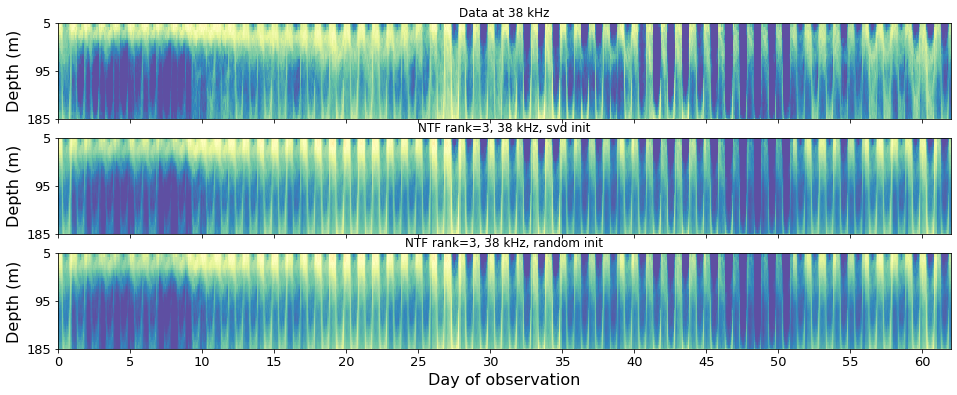

In [18]:
compare_reconstruction(0,38)

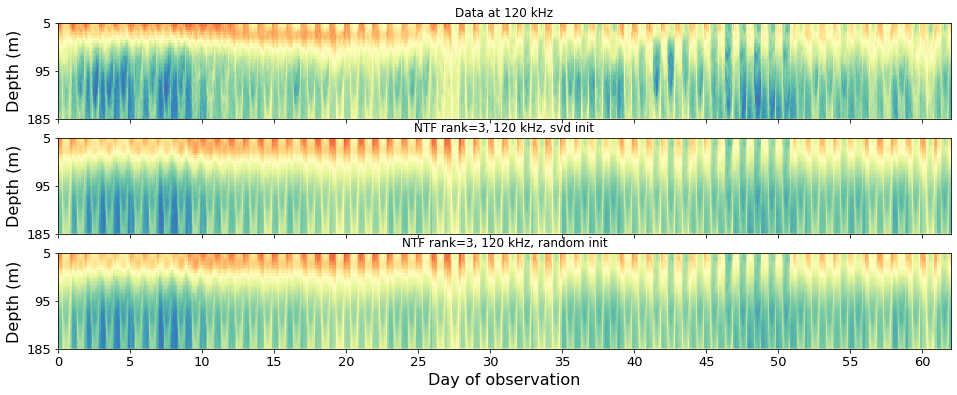

In [19]:
compare_reconstruction(1,120)

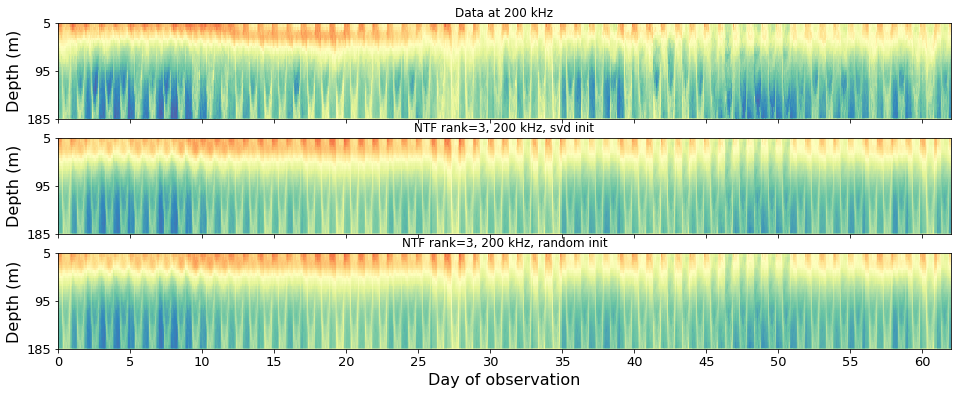

In [20]:
compare_reconstruction(2,200)

In [21]:
def plot_component_daily_echogram(fac):
    fig,ax = plt.subplots(1,3,figsize=(10,2.5))
    for i in range(3):
        im = ax[i].imshow(fac.factors[2][:,i].reshape((37,24))[::-1,:],
                          aspect='auto',cmap='Spectral_r')
        ax[i].set_title('Component %d'% i, fontsize=14)
        ax[i].set_xticks(np.arange(0,25,6))
        ax[i].set_yticks(range(0,37,18))
        ax[i].set_yticklabels((np.arange(0,37,18)+1)*depth_bin_size)
        ax[i].set_xlabel('Hour (kHz)', fontsize=14)
        if ax[i].is_first_col():
            ax[i].set_ylabel('Depth (m)', fontsize=14)
        fig.colorbar(im, ax=ax[i])
    plt.tight_layout()
    plt.show()

In [22]:
def plot_component_freq_activation(fac):
    fig = plt.figure(figsize=(12,2.5), constrained_layout=True)
    gs = fig.add_gridspec(1, 3)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(fac.factors[0],'o-',linewidth=3,markersize=8)
    ax1.set_xticks(range(3))
    ax1.set_xticklabels([38,120,200], fontsize=12)
    ax1.set_xlabel('Frequency (kHz)', fontsize=14)
    ax1.set_ylabel('Relative strength', fontsize=14)

    ax2 = fig.add_subplot(gs[0, 1:])
    ax2.plot(fac.factors[1],'-',linewidth=3,markersize=10)
    ax2.set_xticks(np.arange(0,62,10))
    ax2.set_xticklabels(np.arange(0,62,10), fontsize=12)
    ax2.set_ylabel('Relative strength', fontsize=14)
    ax2.set_xlabel('Day',fontsize=14)
    ax2.set_xlim([0, 61])

    plt.show()

### Components with SVD initialization

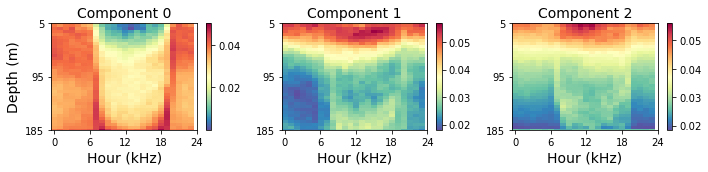

In [23]:
plot_component_daily_echogram(nonneg_3_svd)

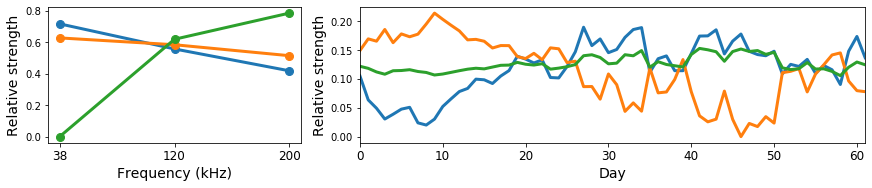

In [24]:
plot_component_freq_activation(nonneg_3_svd)

In [25]:
nonneg_3_svd.weights

array([4270.49497783, 4271.63098325, 4272.10317884])

### Components with random initialization

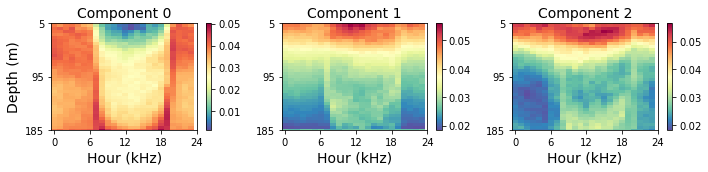

In [26]:
plot_component_daily_echogram(nonneg_3_rand)

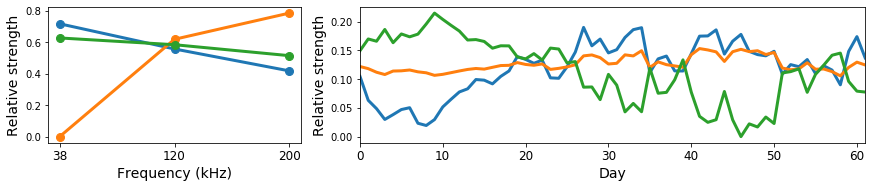

In [27]:
plot_component_freq_activation(nonneg_3_rand)

In [28]:
nonneg_3_rand.weights

array([4273.06946459, 4274.65415506, 4274.19821033])